## Part A: Loading/Preprocessing Rotten Tomatoes Data


In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Read in the data
df=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/rotten-tomatoes-analysis/main/data/rotten_tomatoes_movies.csv")
print(df.shape)

(17712, 22)


In [2]:
del df['rotten_tomatoes_link'], df['tomatometer_top_critics_count'], df['tomatometer_fresh_critics_count'], df['tomatometer_rotten_critics_count']

In [3]:
#Create new features
df[['og_year','og_month','og_day']] = df['original_release_date'].str.split('-',expand=True)
df[['str_year','str_month','str_day']] = df['streaming_release_date'].str.split('-',expand=True)
df['num_actors'] = df['actors'].str.count(',')+1
df['num_actors_group'] = pd.cut(df['num_actors'],
                      bins=[0, 5, 10, 25, 100, float('Inf')],
                      labels=['0-10', '10-25', '25-50','50-100','100+'])

In [4]:
df = df[(df['og_year'].notna()) & (df['str_year'].notna())]
df.shape

(16305, 26)

In [5]:
#Convert time features to integers
df['og_year'] = df['og_year'].astype(int)
df['str_year'] = df['str_year'].astype(int)

df['og_month'] = df['og_month'].astype(int)
df['str_month'] = df['str_month'].astype(int)

df['og_day'] = df['og_day'].astype(int)
df['str_day'] = df['str_day'].astype(int)

In [6]:
#!pip install nltk
from nltk.tokenize import RegexpTokenizer
#!pip install contractions
import contractions
import re

def punct(text):
    token=RegexpTokenizer(r'\w+')#regex
    text = token.tokenize(text)
    text= " ".join(text)
    return text 

def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

def remove_digits(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

def lemmatize(text):
    lemmed = contractions.fix(str(text))
    return lemmed

In [7]:
#Apply standardizing functions to synopsis and critic text
from nltk.corpus import stopwords

stop = stopwords.words('english')

#0.) Convert everything to string
df['cleaned_movie_info'] = df['movie_info'].astype(str)
df['cleaned_critics_consensus'] = df['critics_consensus'].astype(str)

#1.) Lowercase
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].str.lower()
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].str.lower()

#2.) Remove punctuation
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = punct)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = punct)

#3.) Remove non alpha-numeric characters
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = remove_special_characters)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = remove_special_characters)

#4.) Remove digits
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = remove_digits)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = remove_digits)

#5.) Lemmatize words
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = lemmatize)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = lemmatize)

#6. Remove stop words
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [8]:
#Set up VADER score to get labels for doing classification later
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
df['synposis_scores_unpack'] = df['cleaned_movie_info'].map(lambda x: sia.polarity_scores(x))
df['critic_scores_unpack'] = df['cleaned_critics_consensus'].map(lambda x: sia.polarity_scores(x))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jonzimmerman/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
df['synopsis_sentiment_score']  = df['synposis_scores_unpack'].apply(lambda score_dict: score_dict['compound'])
df['synopsis_sentiment_class'] = df['synopsis_sentiment_score'].apply(lambda x: 1 if x >=0 else 0)
df['critic_sentiment_score']  = df['critic_scores_unpack'].apply(lambda score_dict: score_dict['compound'])
df['critic_sentiment_class'] = df['critic_sentiment_score'].apply(lambda x: 1 if x >=0 else 0)
df.head(2)

movie_title  \
0  Percy Jackson & the Olympians: The Lightning T...   
1                                        Please Give   

                                          movie_info  \
0  Always trouble-prone, the life of teenager Per...   
1  Kate (Catherine Keener) and her husband Alex (...   

                                   critics_consensus content_rating  \
0  Though it may seem like just another Harry Pot...             PG   
1  Nicole Holofcener's newest might seem slight i...              R   

                                              genres          directors  \
0  Action & Adventure, Comedy, Drama, Science Fic...     Chris Columbus   
1                                             Comedy  Nicole Holofcener   

                                      authors  \
0  Craig Titley, Chris Columbus, Rick Riordan   
1                           Nicole Holofcener   

                                              actors original_release_date  \
0  Logan Lerman, Brandon T. Jackson, Alexandra Da...            2010-02-12   
1  Catherine Keener, Amanda Peet, Oliver Platt, R...            2010-04-30   

  streaming_release_date  ...  num_actors num_actors_group  \
0             2015-11-25  ...        87.0           50-100   
1             2012-09-04  ...         8.0            10-25   

                                  cleaned_movie_info  \
0  always trouble prone life teenager percy jacks...   
1  kate catherine keener husband alex oliver plat...   

                           cleaned_critics_consensus  \
0  though may seem like another harry potter knoc...   
1  nicole holofcener newest might seem slight pla...   

                              synposis_scores_unpack  \
0  {'neg': 0.215, 'neu': 0.55, 'pos': 0.235, 'com...   
1  {'neg': 0.089, 'neu': 0.789, 'pos': 0.121, 'co...   

                                critic_scores_unpack  \
0  {'neg': 0.0, 'neu': 0.507, 'pos': 0.493, 'comp...   
1  {'neg': 0.0, 'neu': 0.857, 'pos': 0.143, 'comp...   

   synopsis_sentiment_score  synopsis_sentiment_class  critic_sentiment_score  \
0                   -0.2023                         0                  0.9274   
1                    0.2023                         1                  0.3612   

   critic_sentiment_class  
0                       1  
1                       1  

[2 rows x 34 columns]

In [10]:
#Get a list of top genres
genre_df = pd.DataFrame(df['genres'].value_counts().head(15)).reset_index()
genre_list = genre_df['index'].values.tolist()


df['genre_squeeze'] = np.where(df['genres'].isin(genre_list),df['genres'],'Other')
df['genre_squeeze'].value_counts()

Other                                            7988
Drama                                            1735
Comedy                                           1132
Comedy, Drama                                     825
Drama, Mystery & Suspense                         682
Art House & International, Drama                  552
Documentary, Special Interest                     516
Documentary                                       408
Horror                                            390
Action & Adventure, Drama                         345
Action & Adventure, Drama, Mystery & Suspense     321
Horror, Mystery & Suspense                        309
Comedy, Drama, Romance                            301
Drama, Romance                                    294
Comedy, Romance                                   255
Art House & International, Comedy, Drama          252
Name: genre_squeeze, dtype: int64

In [11]:
# One-hot encode genres
one_hot = pd.get_dummies(df['genre_squeeze'])
df = df.drop('genre_squeeze',axis = 1)
df = df.join(one_hot)

In [12]:
df['Art House & International'] = df['Art House & International, Comedy, Drama'] + df['Art House & International, Drama']
del df['Art House & International, Comedy, Drama'], df['Art House & International, Drama']


df['Documentary'] = df['Documentary, Special Interest'] + df['Documentary']        
del df['Documentary, Special Interest']

df['Comedy'] = df['Comedy, Drama'] + df['Comedy'] + df['Comedy, Romance'] + df['Comedy, Drama, Romance']
del df['Comedy, Drama'], df['Comedy, Romance'], df['Comedy, Drama, Romance']


df['Horror'] = df['Horror'] + df['Horror, Mystery & Suspense']
del df['Horror, Mystery & Suspense']


df['Action & Adventure'] = df['Action & Adventure, Drama'] + df['Action & Adventure, Drama, Mystery & Suspense']
del df['Action & Adventure, Drama'], df['Action & Adventure, Drama, Mystery & Suspense']


df['Drama'] = df['Drama'] + df['Drama, Romance'] + df['Drama, Mystery & Suspense']
del df['Drama, Romance'], df['Drama, Mystery & Suspense']
df.columns

Index(['movie_title', 'movie_info', 'critics_consensus', 'content_rating',
       'genres', 'directors', 'authors', 'actors', 'original_release_date',
       'streaming_release_date', 'runtime', 'production_company',
       'tomatometer_status', 'tomatometer_rating', 'tomatometer_count',
       'audience_status', 'audience_rating', 'audience_count', 'og_year',
       'og_month', 'og_day', 'str_year', 'str_month', 'str_day', 'num_actors',
       'num_actors_group', 'cleaned_movie_info', 'cleaned_critics_consensus',
       'synposis_scores_unpack', 'critic_scores_unpack',
       'synopsis_sentiment_score', 'synopsis_sentiment_class',
       'critic_sentiment_score', 'critic_sentiment_class', 'Comedy',
       'Documentary', 'Drama', 'Horror', 'Other', 'Art House & International',
       'Action & Adventure'],
      dtype='object')

In [13]:
#Convert date column format
from datetime import datetime, date 
df['date'] = pd.to_datetime(df['original_release_date'], format = '%Y/%m/%d')

#Filter to 2000 and beyond
df = df[df['original_release_date']>='2000-01-01']
print(df.shape)

(10670, 42)


In [14]:
#Check out genre df sizes
horror = df[df['Horror']==1]
comedy = df[df['Comedy']==1]
drama = df[df['Drama']==1]
act_adv = df[df['Action & Adventure']==1]


print('# of Horror Movies: ',horror.shape[0])
print('# of Comedy Movies: ',horror.shape[0])
print('# of Drama Movies: ',horror.shape[0])
print('# of Action/Adventure Movies: ',act_adv.shape[0])

# of Horror Movies:  516
# of Comedy Movies:  516
# of Drama Movies:  516
# of Action/Adventure Movies:  403


In [15]:
horror.head(3)

movie_title                                         movie_info  \
33         Malevolence  Bank robbers (Brandon Johnson, Heather Magee) ...   
34             Eternal  A detective's (Conrad Pla) search for his miss...   
51  Rise: Blood Hunter  Sadie (Lucy Liu), a reporter, investigates an ...   

                                    critics_consensus content_rating  \
33                                                NaN              R   
34  Even by the standards of camp, Eternal fails t...              R   
51                                                NaN              R   

                        genres                             directors  \
33                      Horror                           Stevan Mena   
34  Horror, Mystery & Suspense  Wilhelm Liebenberg, Federico Sanchez   
51  Horror, Mystery & Suspense                   Sebastian Gutierrez   

                                 authors  \
33                           Stevan Mena   
34  Wilhelm Liebenberg, Federico Sanchez   
51                   Sebastian Gutierrez   

                                               actors original_release_date  \
33  Samantha Dark, R. Brandon Johnson, Heather Mag...            2004-09-10   
34  Sarah Manninen, Caroline Neron, Victoria Sanch...            2004-08-26   
51  Lucy Liu, Michael Chiklis, Carla Gugino, James...            2007-06-01   

   streaming_release_date  ...  critic_sentiment_score critic_sentiment_class  \
33             2017-03-30  ...                   0.000                      1   
34             2016-09-23  ...                  -0.128                      0   
51             2016-11-01  ...                   0.000                      1   

   Comedy  Documentary  Drama Horror  Other  Art House & International  \
33      0            0      0      1      0                          0   
34      0            0      0      1      0                          0   
51      0            0      0      1      0                          0   

    Action & Adventure       date  
33                   0 2004-09-10  
34                   0 2004-08-26  
51                   0 2007-06-01  

[3 rows x 42 columns]

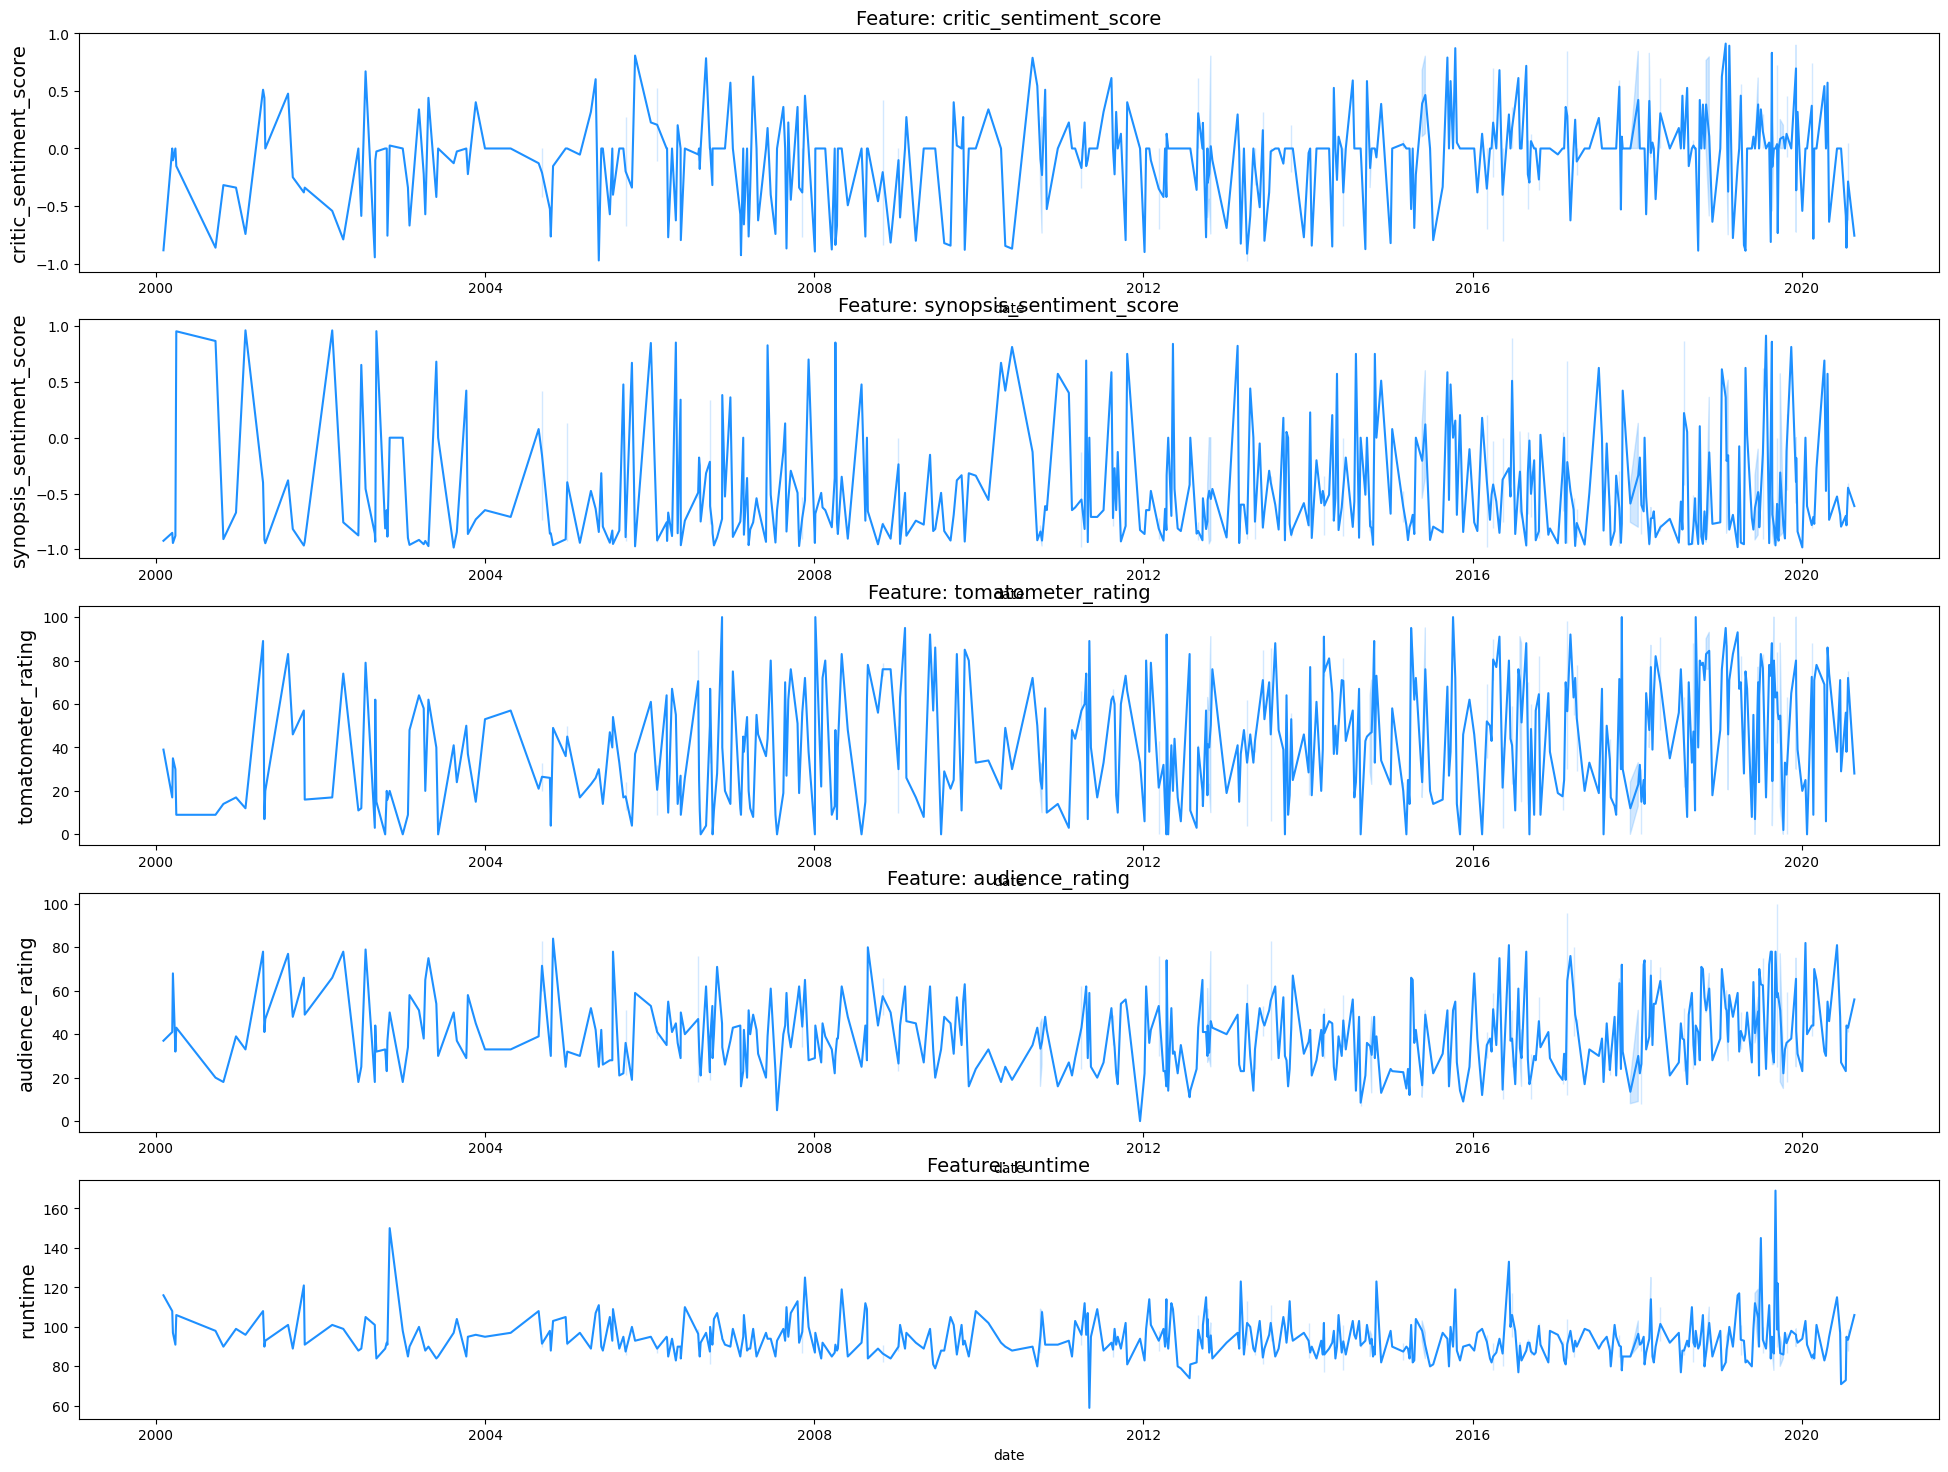

In [16]:
#Plot timelines of main quantitative factors
import seaborn as sns
list_of_cols = ['critic_sentiment_score','synopsis_sentiment_score','tomatometer_rating','audience_rating','runtime']
list_of_colors = ['blue','green','orange','red','purple']
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(24, 18))

for i, column in enumerate(list_of_cols):
    
    sns.lineplot(x=horror['date'], y=horror[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)

## Part B: Referencing Kaggle


https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide

### Part B1: Data Viz


In [17]:
#Filter data down a bit
filter_df = horror[['date','critic_sentiment_score','synopsis_sentiment_score','tomatometer_rating','audience_rating','runtime']]
filter_df.head()

date  critic_sentiment_score  synopsis_sentiment_score  \
33 2004-09-10                  0.0000                   -0.7351   
34 2004-08-26                 -0.1280                    0.0772   
51 2007-06-01                  0.0000                   -0.9325   
56 2006-03-24                 -0.7717                   -0.6705   
74 2007-03-09                  0.0000                   -0.3612   

    tomatometer_rating  audience_rating  runtime  
33                33.0             83.0     90.0  
34                21.0             39.0    108.0  
51                36.0             20.0     97.0  
56                10.0             55.0     85.0  
74                54.0             20.0     88.0

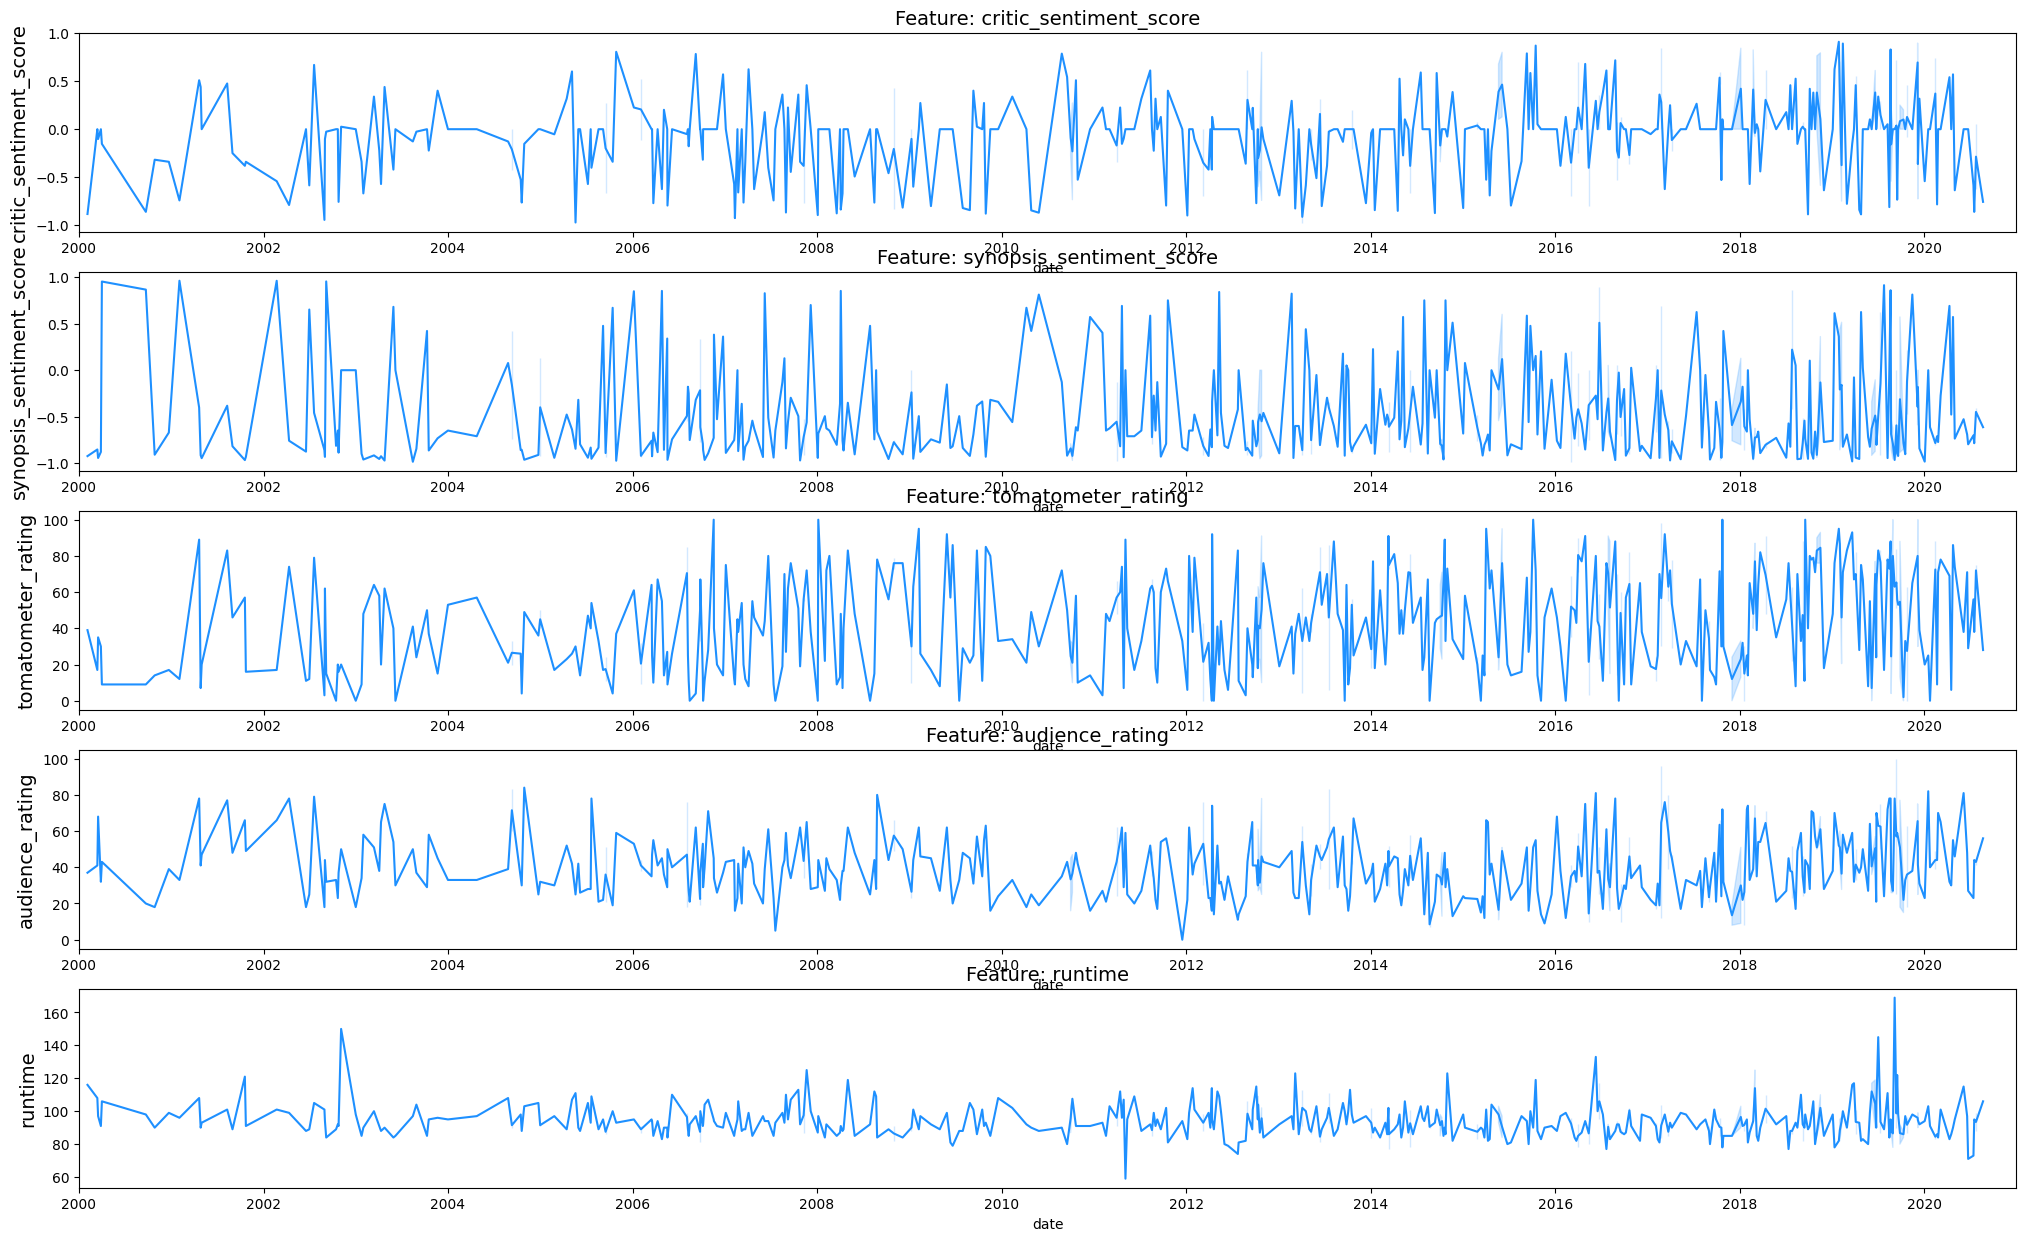

In [18]:
# To complete the data, as naive method, we will use ffill
import seaborn as sns
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(25, 15))

for i, column in enumerate(filter_df.drop('date', axis=1).columns):
    sns.lineplot(x=filter_df['date'], y=filter_df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2000, 1, 1), date(2020, 12, 31)])

### Part B2: Data Preprocessing

Chronological Order and Equidistant Timestamps

The data should be in chronological order and the timestamps should be equidistant in the time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicate constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.

Let's see how to check if our dataset is correctly formated!

In [19]:
#Create new dataframe with one row per day
df = horror.groupby('date').agg({
    'critic_sentiment_score': 'mean',
    'synopsis_sentiment_score':'mean',
    'tomatometer_rating':'mean',
    'audience_rating':'mean',
    'runtime':'mean'
}).reset_index()
df.head()

date  critic_sentiment_score  synopsis_sentiment_score  \
0 2000-02-04                 -0.8848                   -0.9231   
1 2000-03-14                  0.0000                   -0.8519   
2 2000-03-17                 -0.1027                   -0.9432   
3 2000-03-28                  0.0000                   -0.8779   
4 2000-04-01                 -0.1531                    0.9527   

   tomatometer_rating  audience_rating  runtime  
0                39.0             37.0    116.0  
1                17.0             41.0    108.0  
2                35.0             68.0     97.0  
3                30.0             32.0     91.0  
4                 9.0             43.0    106.0

In [20]:
df = df.sort_values(by='date')

# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)
df[['date', 'delta']].head()

date   delta
0 2000-02-04     NaT
1 2000-03-14 39 days
2 2000-03-17  3 days
3 2000-03-28 11 days
4 2000-04-01  4 days

In [21]:
df['delta'].sum(), df['delta'].count()

(Timedelta('7504 days 00:00:00'), 430)

In [22]:
df = df.drop('delta', axis=1)
df.isna().sum()

date                        0
critic_sentiment_score      0
synopsis_sentiment_score    0
tomatometer_rating          0
audience_rating             1
runtime                     1
dtype: int64

(14610.0, 18262.0)

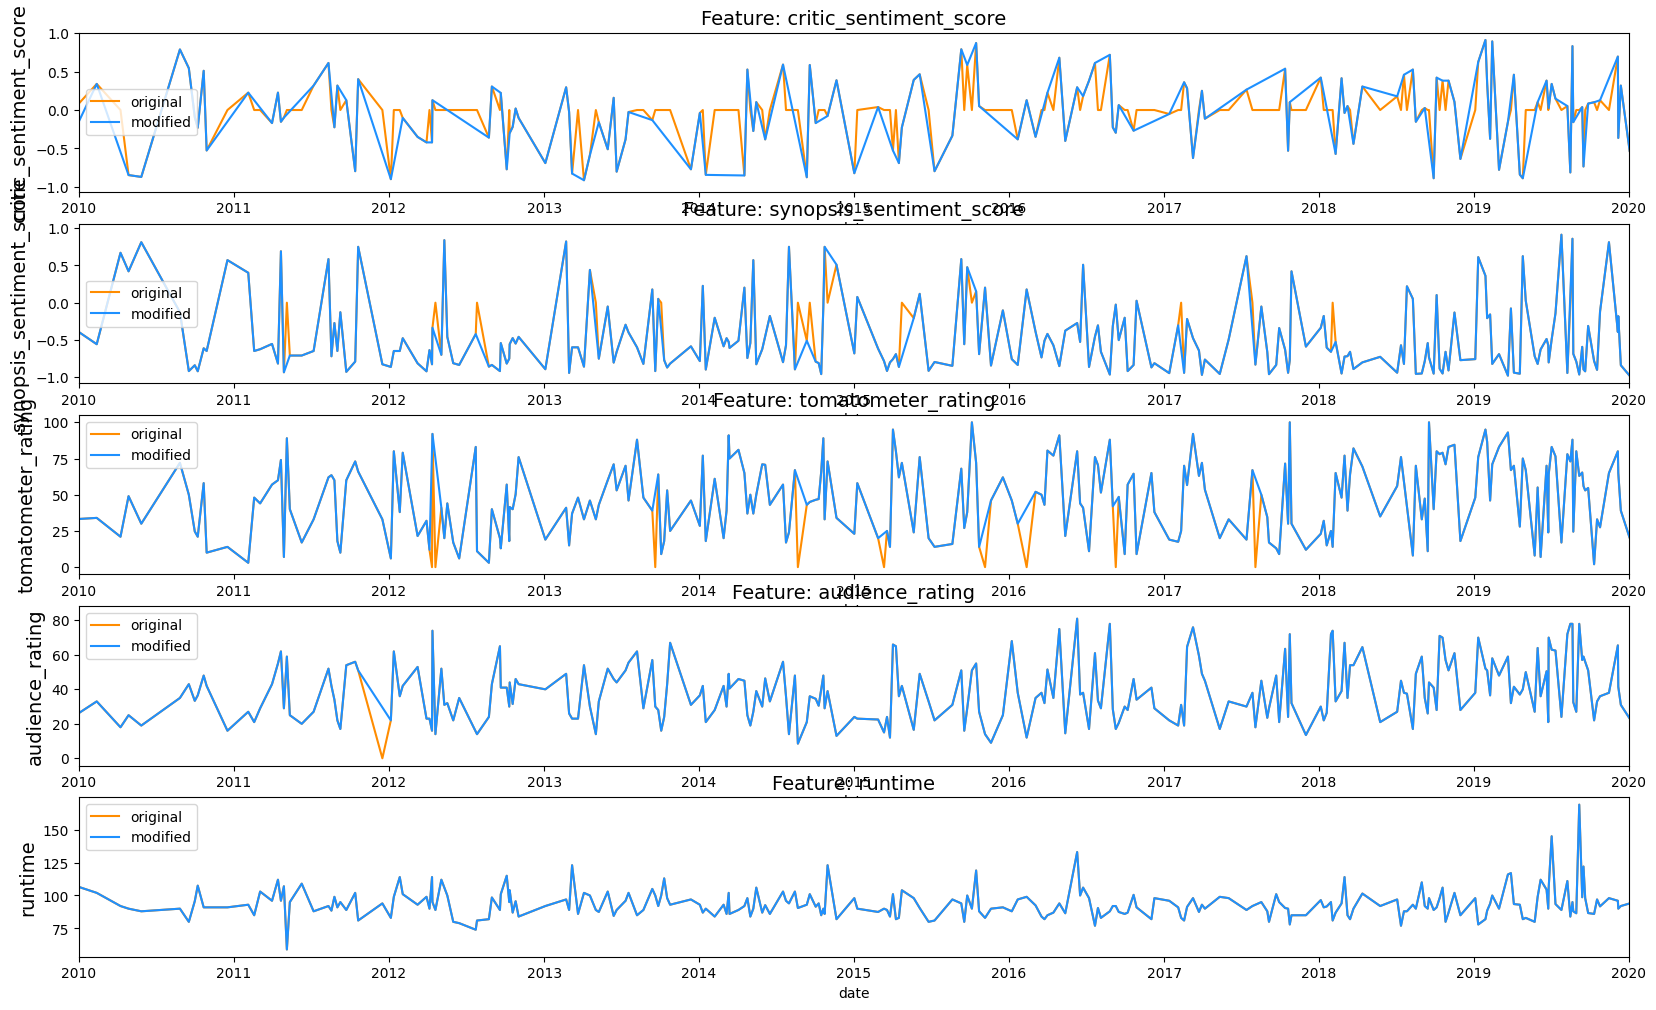

In [23]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(20, 12))

old_critic = df['critic_sentiment_score'].copy()
df['critic_sentiment_score'] = df['critic_sentiment_score'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_critic, ax=ax[0], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')
ax[0].set_title('Feature: critic_sentiment_score', fontsize=14)
ax[0].set_ylabel(ylabel='critic_sentiment_score', fontsize=14)
ax[0].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])

old_synop = df['synopsis_sentiment_score'].copy()
df['synopsis_sentiment_score'] = df['synopsis_sentiment_score'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_synop, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['synopsis_sentiment_score'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: synopsis_sentiment_score', fontsize=14)
ax[1].set_ylabel(ylabel='synopsis_sentiment_score', fontsize=14)
ax[1].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])


old_tomato = df['tomatometer_rating'].copy()
df['tomatometer_rating'] = df['tomatometer_rating'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_tomato, ax=ax[2], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['tomatometer_rating'].fillna(np.inf), ax=ax[2], color='dodgerblue', label='modified')
ax[2].set_title('Feature: tomatometer_rating', fontsize=14)
ax[2].set_ylabel(ylabel='tomatometer_rating', fontsize=14)
ax[2].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])

old_audience = df['audience_rating'].copy()
df['audience_rating'] = df['audience_rating'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_audience, ax=ax[3], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['audience_rating'].fillna(np.inf), ax=ax[3], color='dodgerblue', label='modified')
ax[3].set_title('Feature: audience_rating', fontsize=14)
ax[3].set_ylabel(ylabel='audience_rating', fontsize=14)
ax[3].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])

old_runtime = df['runtime'].copy()
df['runtime'] = df['runtime'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_runtime, ax=ax[4], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['runtime'].fillna(np.inf), ax=ax[4], color='dodgerblue', label='modified')
ax[4].set_title('Feature: runtime', fontsize=14)
ax[4].set_ylabel(ylabel='runtime', fontsize=14)
ax[4].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])

Now we have to fix the missing values.

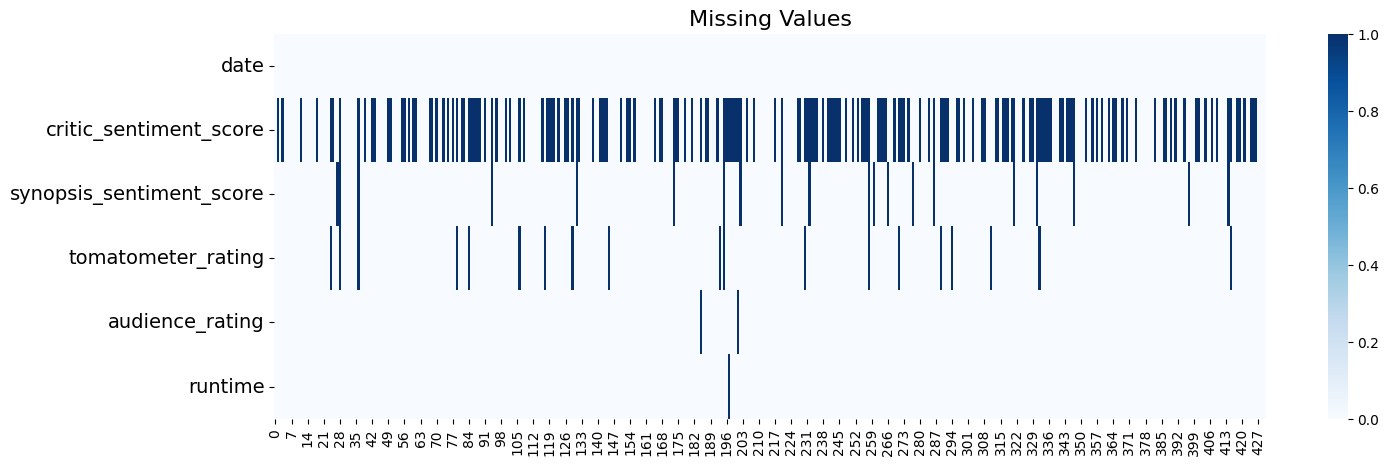

In [24]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

### Part B3: Handling Missing Values

Option 1: Fill NaN with Outlier or Zero In this specific example filling the missing value with an outlier value such as np.inf or 0 seems to be very naive. However, using values like -999, is sometimes a good idea.

Option 2: Fill NaN with Mean Value Filling NaNs with the mean value is also not sufficient and naive, and doesn't seems to be a good option.

Option 3: Fill NaN with Last Value with .ffill() Filling NaNs with the last value could be bit better.

Option 4: Fill NaN with Linearly Interpolated Value with .interpolate() Filling NaNs with the interpolated values is the best option in this small examlple but it requires knowledge of the neighouring value

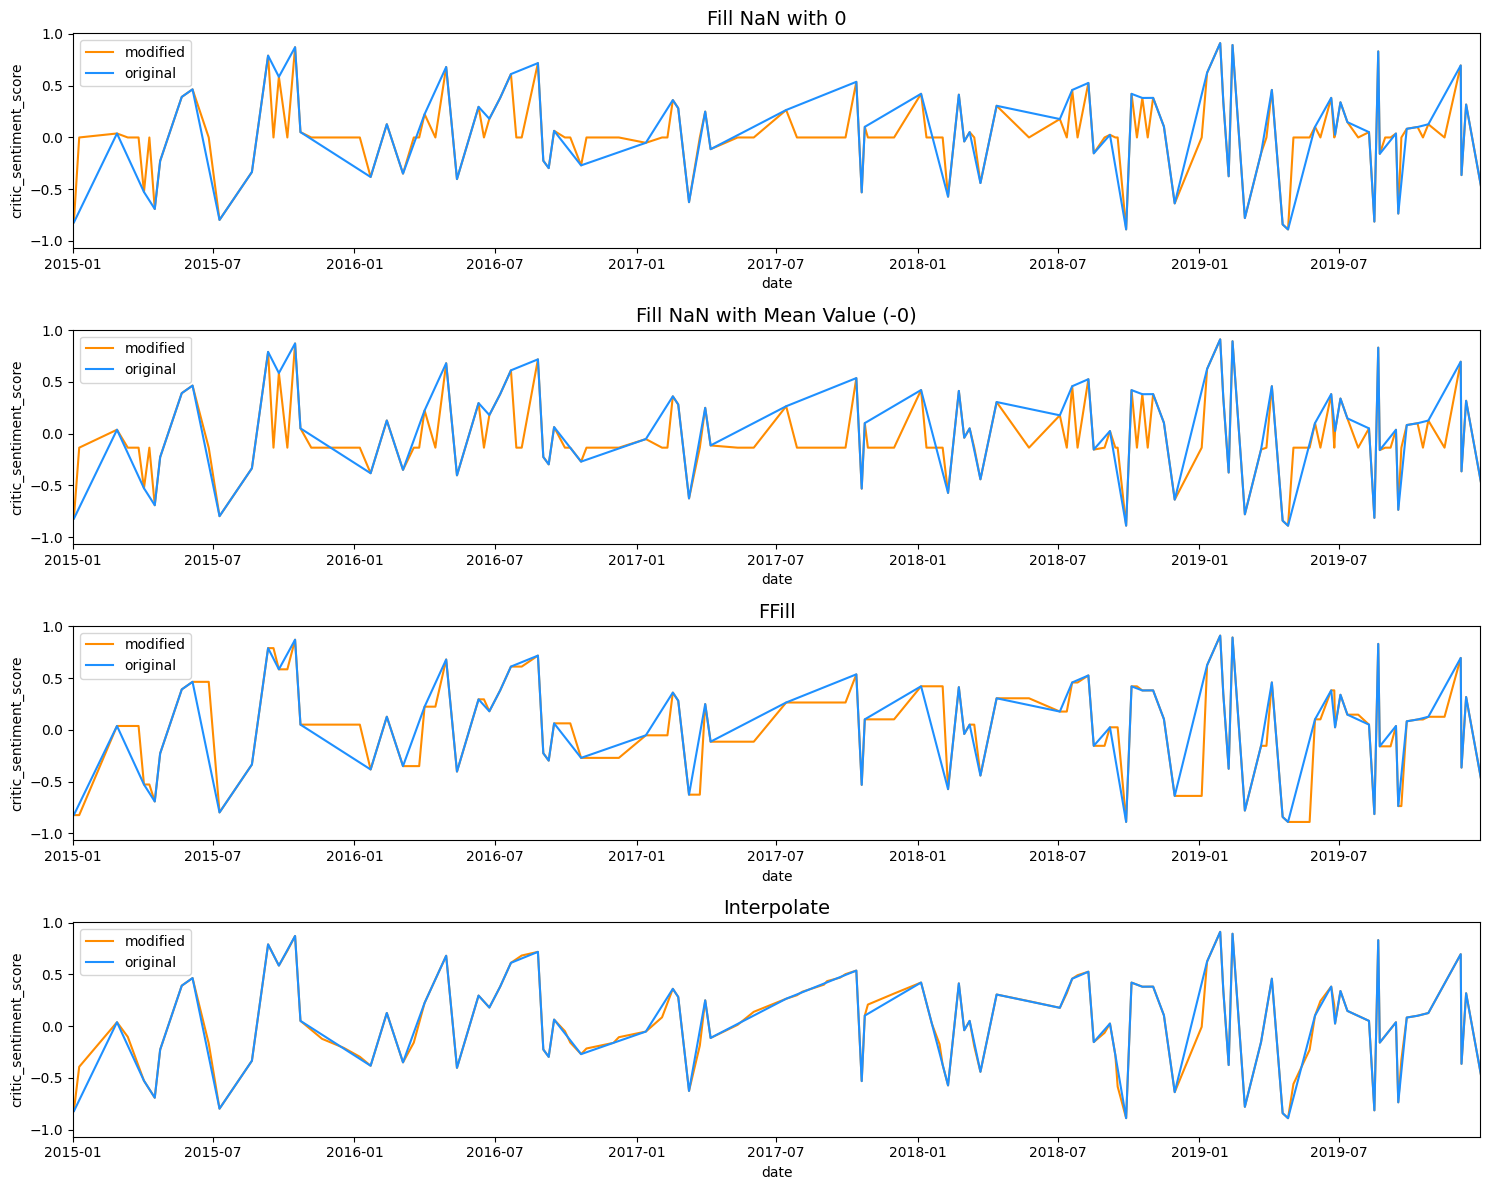

In [25]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)

mean_critc_sentiment = df['critic_sentiment_score'].mean()
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(mean_critc_sentiment), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_critc_sentiment:.0f})', fontsize=14)

sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)

sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2015, 1, 1), date(2019, 12, 31)])
    
plt.tight_layout()
plt.show()

Fill NAs with 0 --> not best solution, but makes sense with context of our data, no movies released, so no critic scores, thus 0

In [26]:
df['critic_sentiment_score'] = df['critic_sentiment_score'].fillna(0)
df['synopsis_sentiment_score'] = df['synopsis_sentiment_score'].fillna(0)
df['tomatometer_rating'] = df['tomatometer_rating'].fillna(0)
df['audience_rating'] = df['audience_rating'].fillna(0)
df['runtime'] = df['runtime'].fillna(0)

df.isnull().sum()

date                        0
critic_sentiment_score      0
synopsis_sentiment_score    0
tomatometer_rating          0
audience_rating             0
runtime                     0
dtype: int64

### Part B4: Smoothing/Resampling

Resampling can provide additional information on the data. There are two types of resampling:

Upsampling is when the frequency of samples is increased (e.g. days to hours)

Downsampling is when the frequency of samples is decreased (e.g. days to weeks) In this example, we will do some downsampling with the .resample() function (similar to groupby and aggregate as mean).

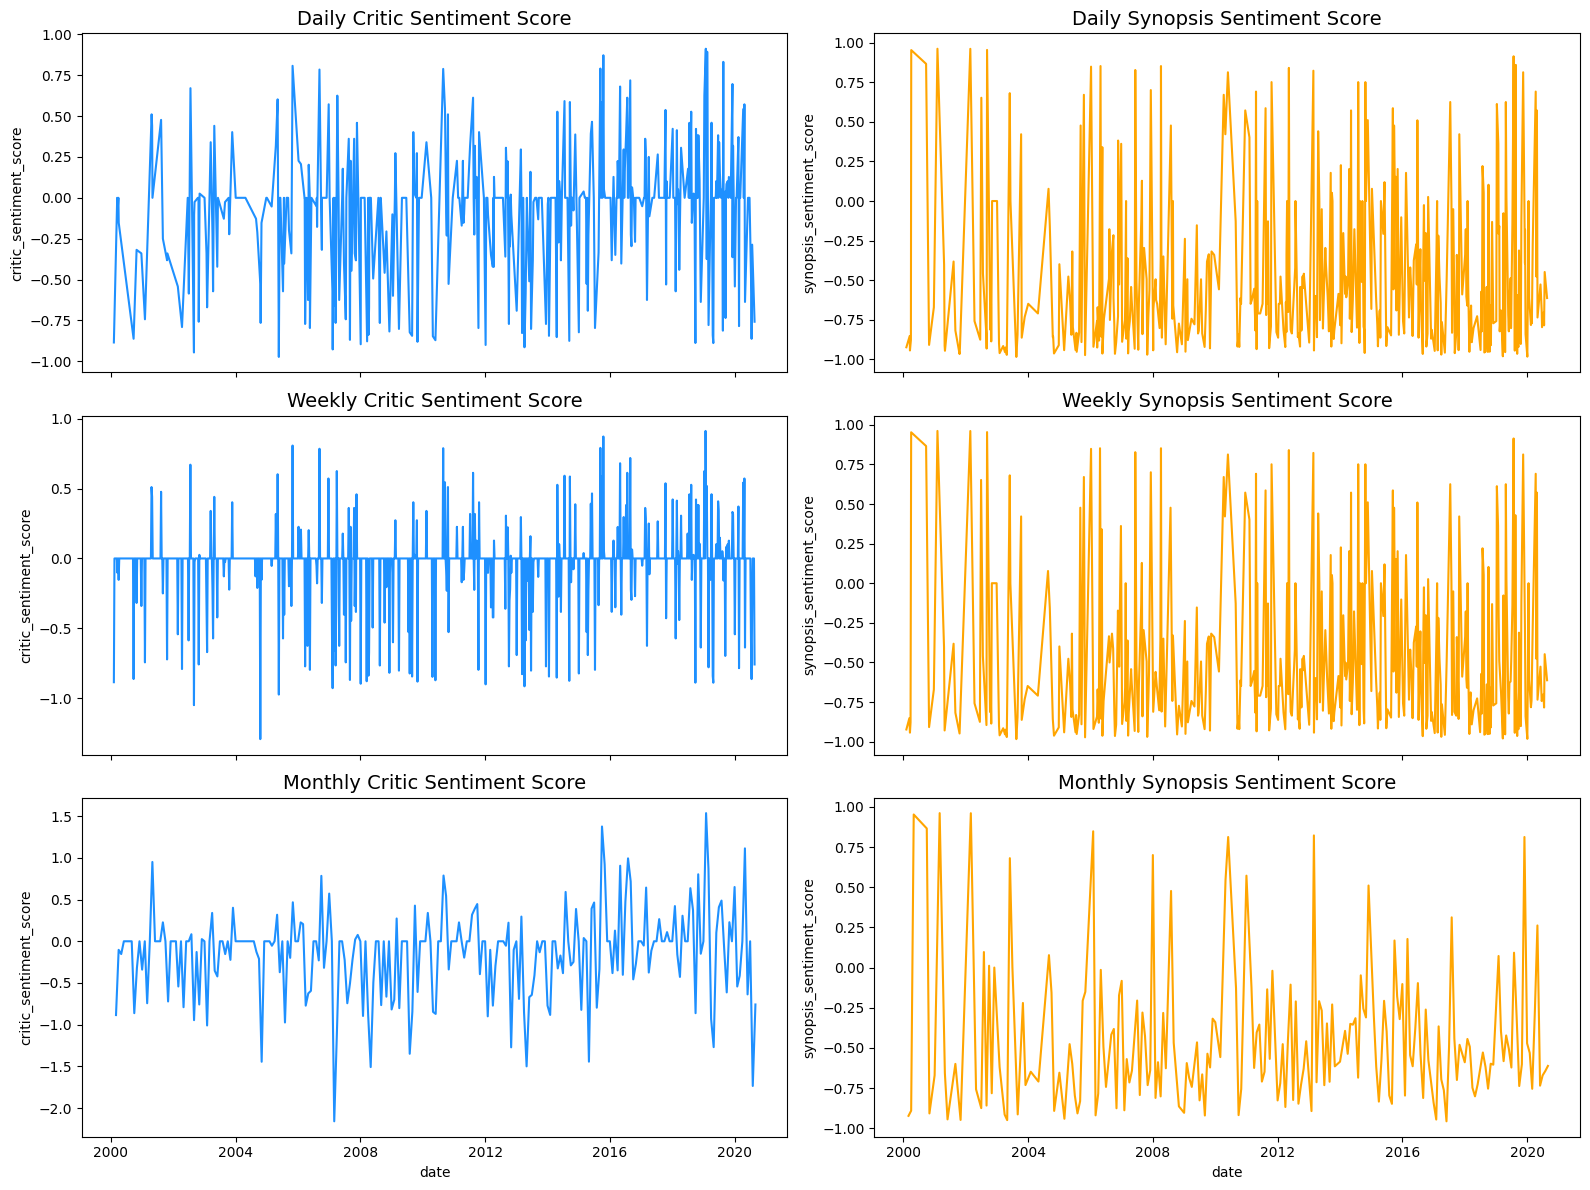

In [27]:
f, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Daily Critic Sentiment Score', fontsize=14)

resampled_df = df[['date','critic_sentiment_score']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['critic_sentiment_score'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Critic Sentiment Score', fontsize=14)

resampled_df = df[['date','critic_sentiment_score']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['critic_sentiment_score'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Critic Sentiment Score', fontsize=14)


sns.lineplot(x=df['date'], y=df['synopsis_sentiment_score'], color='orange', ax=ax[0, 1])
ax[0, 1].set_title('Daily Synopsis Sentiment Score', fontsize=14)

resampled_df = df[['date','synopsis_sentiment_score']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['synopsis_sentiment_score'], color='orange', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Synopsis Sentiment Score', fontsize=14)

resampled_df = df[['date','synopsis_sentiment_score']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['synopsis_sentiment_score'], color='orange', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Synopsis Sentiment Score', fontsize=14)

plt.tight_layout()
plt.show()

In [28]:
# As we can see, downsample to weekly could smooth the data and help with analysis
downsample = df[['date', 'critic_sentiment_score', 'synopsis_sentiment_score','tomatometer_rating', 'audience_rating','runtime'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()
df.head(3)

date  critic_sentiment_score  synopsis_sentiment_score  \
0 2000-02-04                 -0.8848                   -0.9231   
1 2000-02-11                     NaN                       NaN   
2 2000-02-18                     NaN                       NaN   

   tomatometer_rating  audience_rating  runtime  
0                39.0             37.0    116.0  
1                 NaN              NaN      NaN  
2                 NaN              NaN      NaN

In [29]:
#Impute last value to make forecasting a little easier down the line
df['critic_sentiment_score'] = df['critic_sentiment_score'].ffill()
df['synopsis_sentiment_score'] = df['synopsis_sentiment_score'].ffill()
df['tomatometer_rating'] = df['tomatometer_rating'].ffill()
df['audience_rating'] = df['audience_rating'].ffill()
df['runtime'] = df['runtime'].ffill()

df.head(3)

date  critic_sentiment_score  synopsis_sentiment_score  \
0 2000-02-04                 -0.8848                   -0.9231   
1 2000-02-11                 -0.8848                   -0.9231   
2 2000-02-18                 -0.8848                   -0.9231   

   tomatometer_rating  audience_rating  runtime  
0                39.0             37.0    116.0  
1                39.0             37.0    116.0  
2                39.0             37.0    116.0

### Part B5: Stationarity

#### Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has
1.) constant mean and mean is not time-dependent

2.) constant variance and variance is not time-dependent

3.) constant covariance and covariance is not time-dependent

#### The check for stationarity can be done via three different approaches:
1.) visually: plot time series and check for trends or seasonality

2.) basic statistics: split time series and compare the mean and variance of each partition

3.) statistical test: Augmented Dickey Fuller test

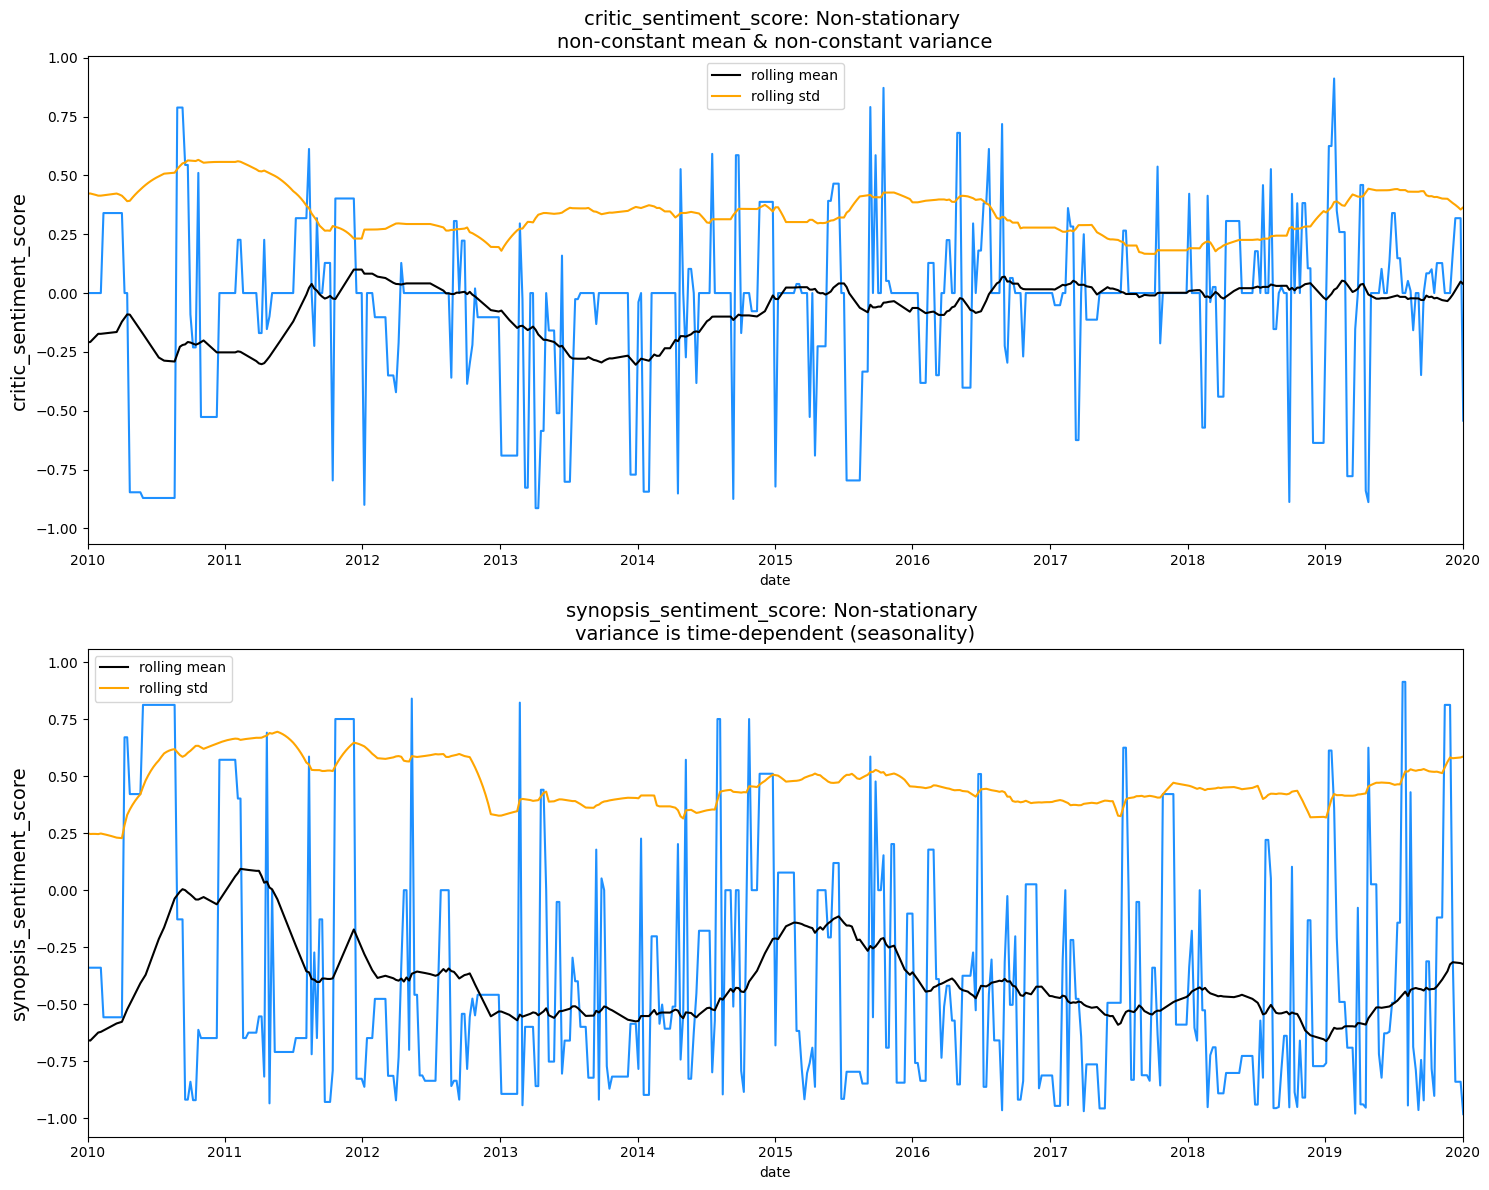

In [30]:
# A year has 52 weeks (52 weeks * 7 days per week) aporx.
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['critic_sentiment_score'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('critic_sentiment_score: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='critic_sentiment_score', fontsize=14)
ax[0].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])

sns.lineplot(x=df['date'], y=df['synopsis_sentiment_score'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['synopsis_sentiment_score'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['synopsis_sentiment_score'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('synopsis_sentiment_score: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='synopsis_sentiment_score', fontsize=14)
ax[1].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])

plt.tight_layout()
plt.show()

### Part B6: Unit Root Test

Unit root is a characteristic of a time series that makes it non-stationary. The ADF test belongs to the unit root test. Technically, a unit root is said to exist in a time series of value of alpha = 1 in the below equation:

Y t = α Y t − 1

β X e

ϵ

where Yt is value of the time series at time ‘t’ and Xe is an exogenous variable .

The presence of a unit root means the time series is non-stationary.

#### Augmented Dickey-Fuller (ADF)
The Augmented Dickey-Fuller (ADF) test is a type of statistical test, which is also referred to as a unit root test. Unit roots are a cause for non-stationarity.

Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

If the null hypothesis can be rejected, we can conclude that the time series is stationary.

There are two ways to rejects the null hypothesis:

#### p-value > significance level (default: 0.05): 
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary. 
#### p-value <= significance level (default: 0.05): 
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

#### ADF statistic > critical value: 
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary. 
#### ADF statistic < critical value: 
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [31]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['critic_sentiment_score'].values)
result

(-11.9090706054928,
 5.349690907644467e-22,
 2,
 1070,
 {'1%': -3.4364762217105844,
  '5%': -2.8642449457774135,
  '10%': -2.5682102104987337},
 426.68828028459166)

Now, we are going to check for each variable:

(1) Check if the p-value is less than 0.05 or (2) check the range of the ADF statistic compared with the critical value.

In [32]:
df.columns

Index(['date', 'critic_sentiment_score', 'synopsis_sentiment_score',
       'tomatometer_rating', 'audience_rating', 'runtime'],
      dtype='object')

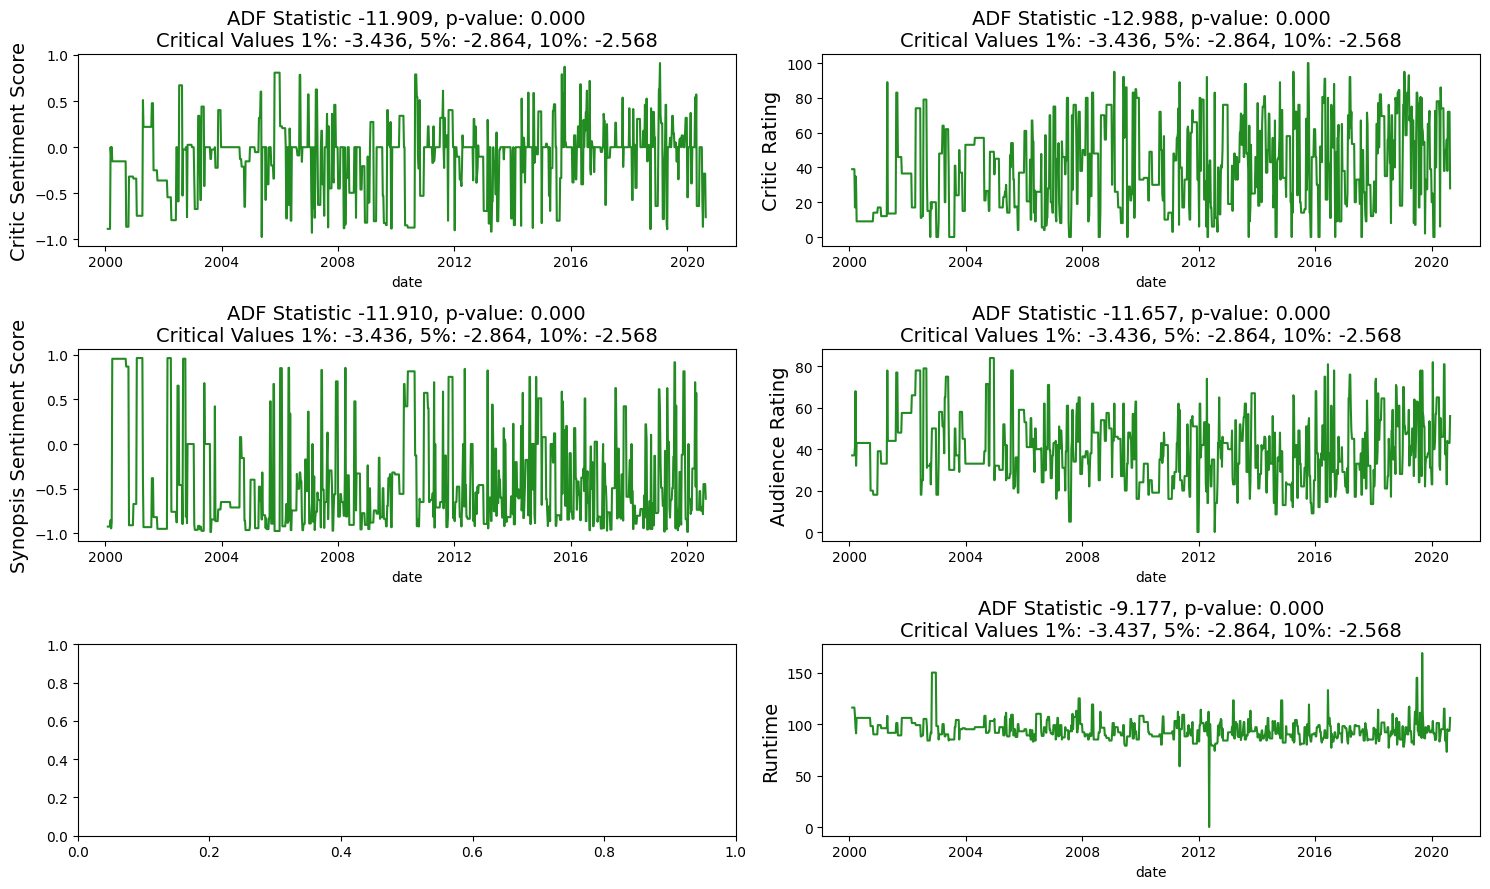

In [33]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['critic_sentiment_score'].values, 'Critic Sentiment Score', ax[0, 0])
visualize_adfuller_results(df['synopsis_sentiment_score'].values, 'Synopsis Sentiment Score', ax[1, 0])
visualize_adfuller_results(df['tomatometer_rating'].values, 'Critic Rating', ax[0, 1])
visualize_adfuller_results(df['audience_rating'].values, 'Audience Rating', ax[1, 1])
visualize_adfuller_results(df['runtime'].values, 'Runtime', ax[2, 1])

plt.tight_layout()
plt.show()

If the data is not stationary, but we want to use a model such as ARIMA (that requires this characteristic), the data has to be transformed.

The two most common methods to transform series into stationarity ones are:

1.) Transformation: e.g. log or square root to stabilize non-constant variance

2.) Differencing: subtracts the current value from the previous

## Part C: Feature Engineering

In [34]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

date  year  month  day  day_of_year  week_of_year  quarter  season
0 2000-02-04  2000      2    4           35             5        1       1
1 2000-02-11  2000      2   11           42             6        1       1
2 2000-02-18  2000      2   18           49             7        1       1
3 2000-02-25  2000      2   25           56             8        1       1
4 2000-03-03  2000      3    3           63             9        1       2

### Part C2: Encode Cyclical Features

The new time features are cyclical. For example, the feature month cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the month feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot of models.

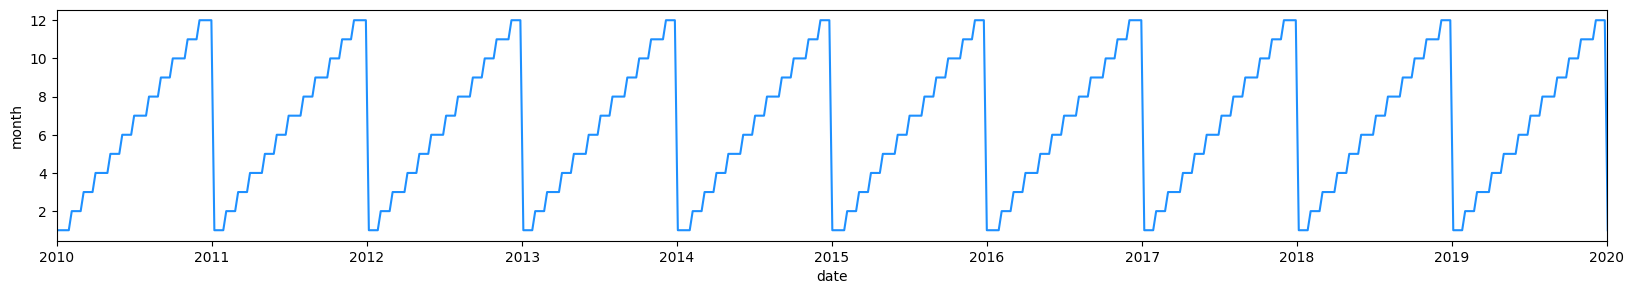

In [35]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='dodgerblue')
ax.set_xlim([date(2010, 1, 1), date(2020, 1, 1)])
plt.show()

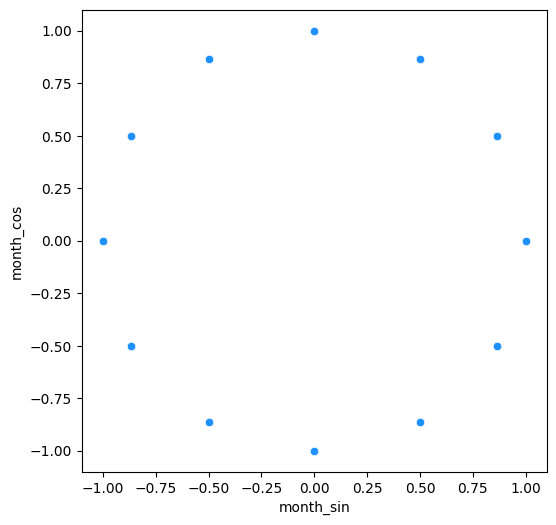

In [36]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

### Part C3: Time Series Decomposition


Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

These components are defined as follows:

(1) Level: The average value in the series. (2) Trend: The increasing or decreasing value in the series. (3) Seasonality: The repeating short-term cycle in the series. (4)Noise: The random variation in the series.

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively:

Additive:
y(t) = Level

Trend

Seasonality 

Noise

Multiplicative:
y(t) = Level ∗ Trend ∗ Seasonality ∗ Noise

In this case we are going to use function seasonal_decompose() from the statsmodels library.

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'critic_sentiment_score', 
    'synopsis_sentiment_score', 
    'tomatometer_rating', 
    'audience_rating',
    'runtime'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

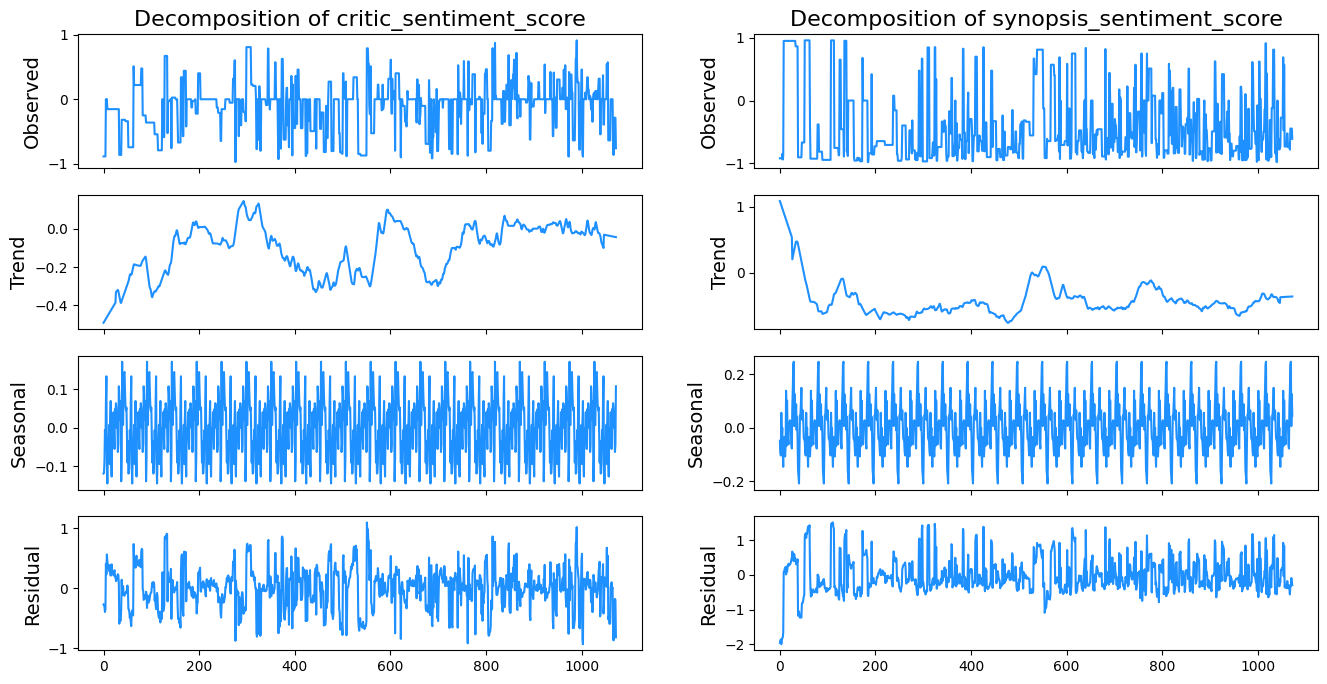

In [38]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['critic_sentiment_score', 'synopsis_sentiment_score']):
    
    res = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

### Part C4: Lag


We want to calculate each variable with a shift() (lag) to compare the correlation with the other variables.



In [39]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

## Part D: Exploratory Data Analysis


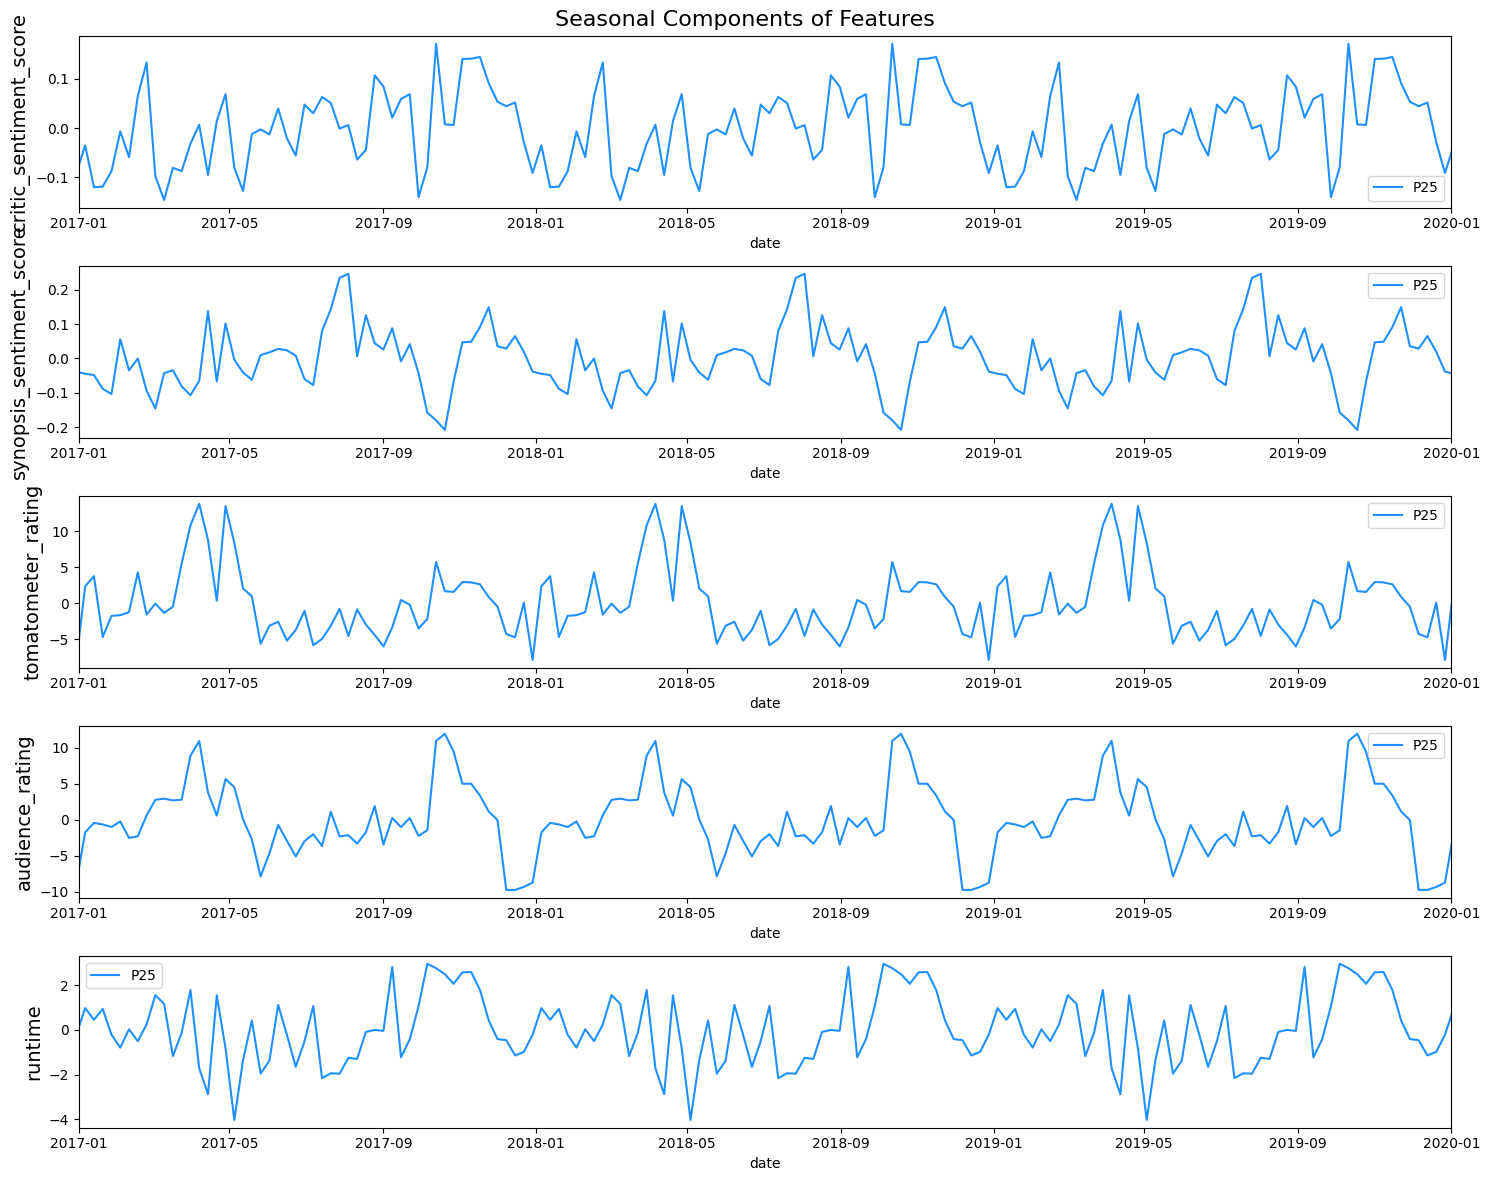

In [40]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 1, 1), date(2020, 1, 1)])
    
plt.tight_layout()
plt.show()

As we can see:

(1) critic_sentiment_score: reaches its min in late September/early March; maximum around late October

(2) synopsis_sentiment_socre: reaches its minimum around early October; max in November

(3) critic rating: reaches its min around early November; max around mid-October

(4) audience_rating: reaches its min November; max around October 

(5) runtime: reaches min around November; max around October

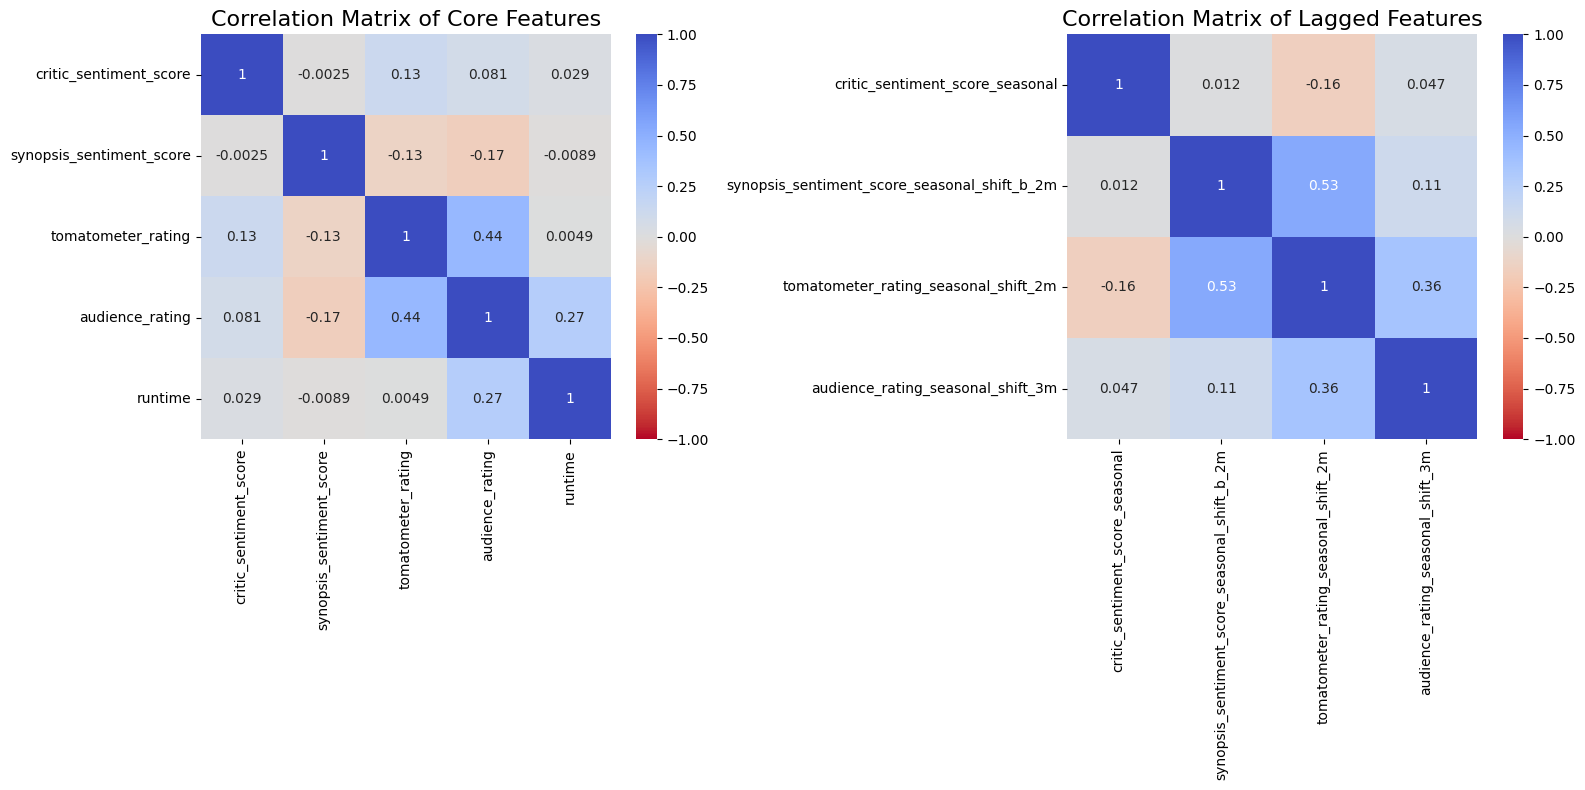

In [41]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'critic_sentiment_score_seasonal',         
    'synopsis_sentiment_score_seasonal_shift_b_2m',
    'tomatometer_rating_seasonal_shift_2m', 
    'audience_rating_seasonal_shift_3m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

As we can see, the features are more highly correlated with the original features rather than the shifted (lagged) ones. Still, not great numbers though.

## Part D2: Autocorrelation Analysis


ACF and PACF plots:

After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. By looking at the autocorrelation function (ACF) and partial autocorrelation (PACF) plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

(1) Autocorrelation Function (ACF): P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter

(2) Partial Autocorrelation Function (PACF): D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

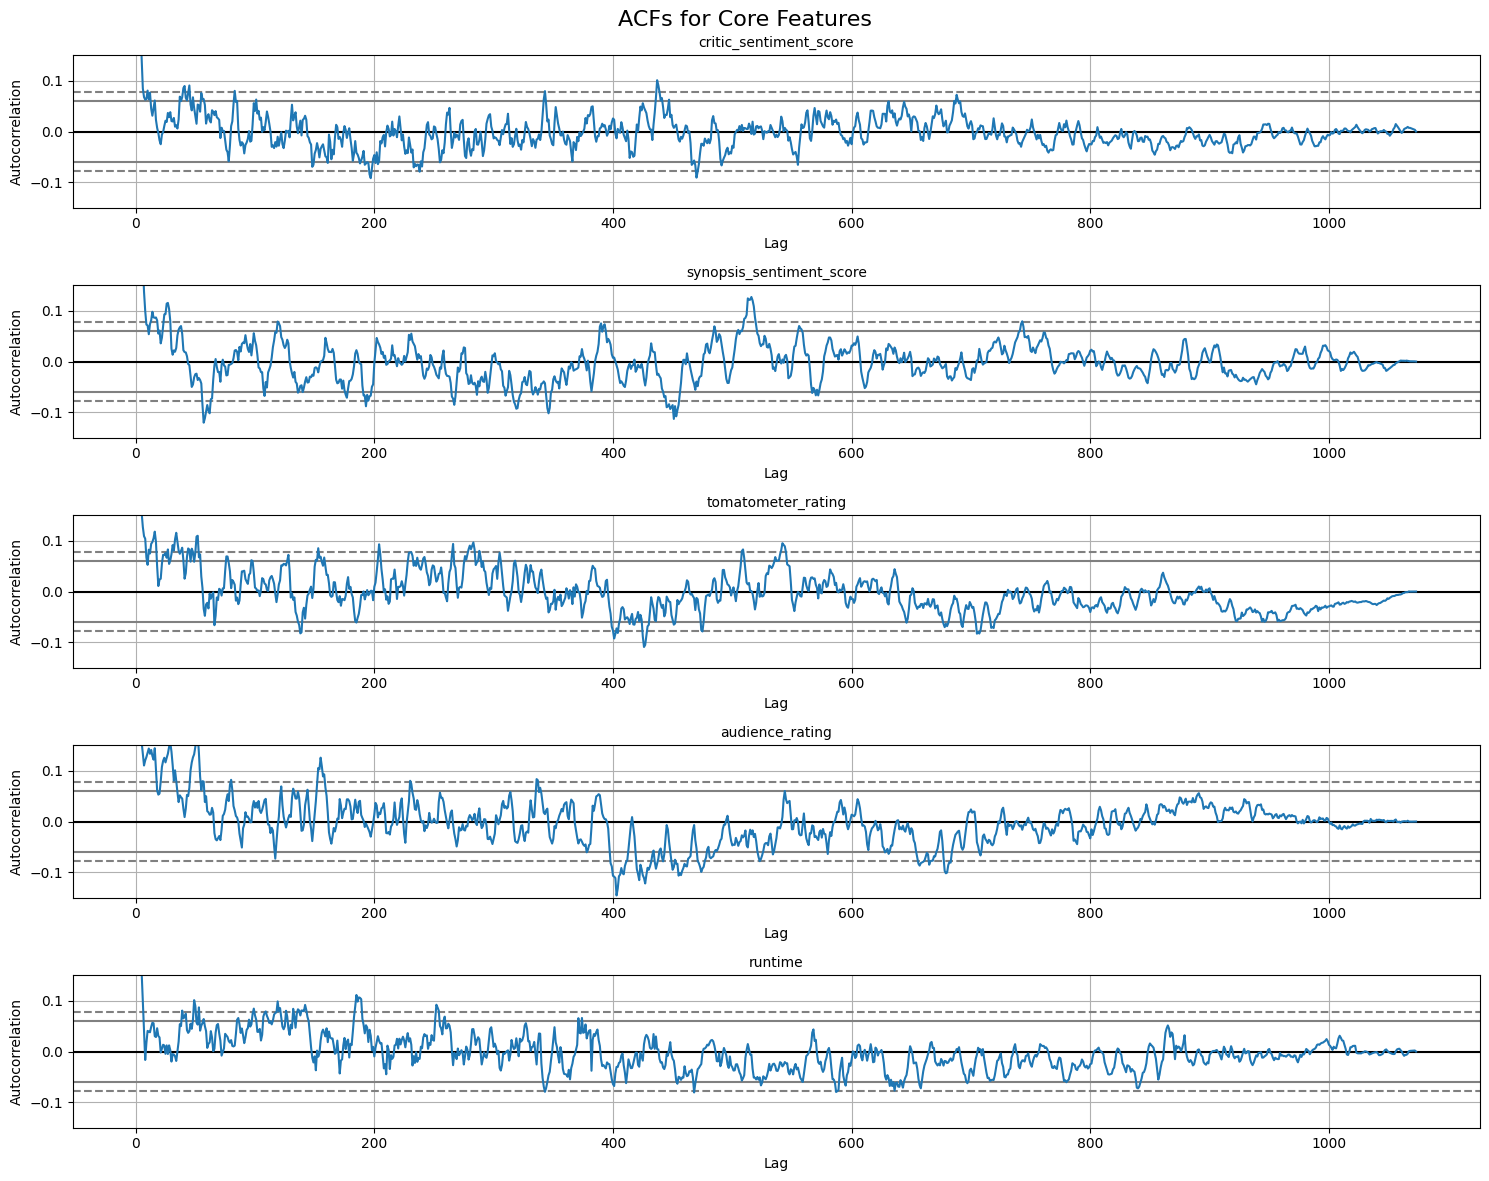

In [42]:
from pandas.plotting import autocorrelation_plot

f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('ACFs for Core Features', fontsize=16)

for i, column in enumerate(core_columns):
    autocorrelation_plot(df[column],ax=ax[i])
    ax[i].set_ylim([-0.15,0.15])
    ax[i].set_title(column, fontsize=10)


plt.tight_layout()
plt.show()

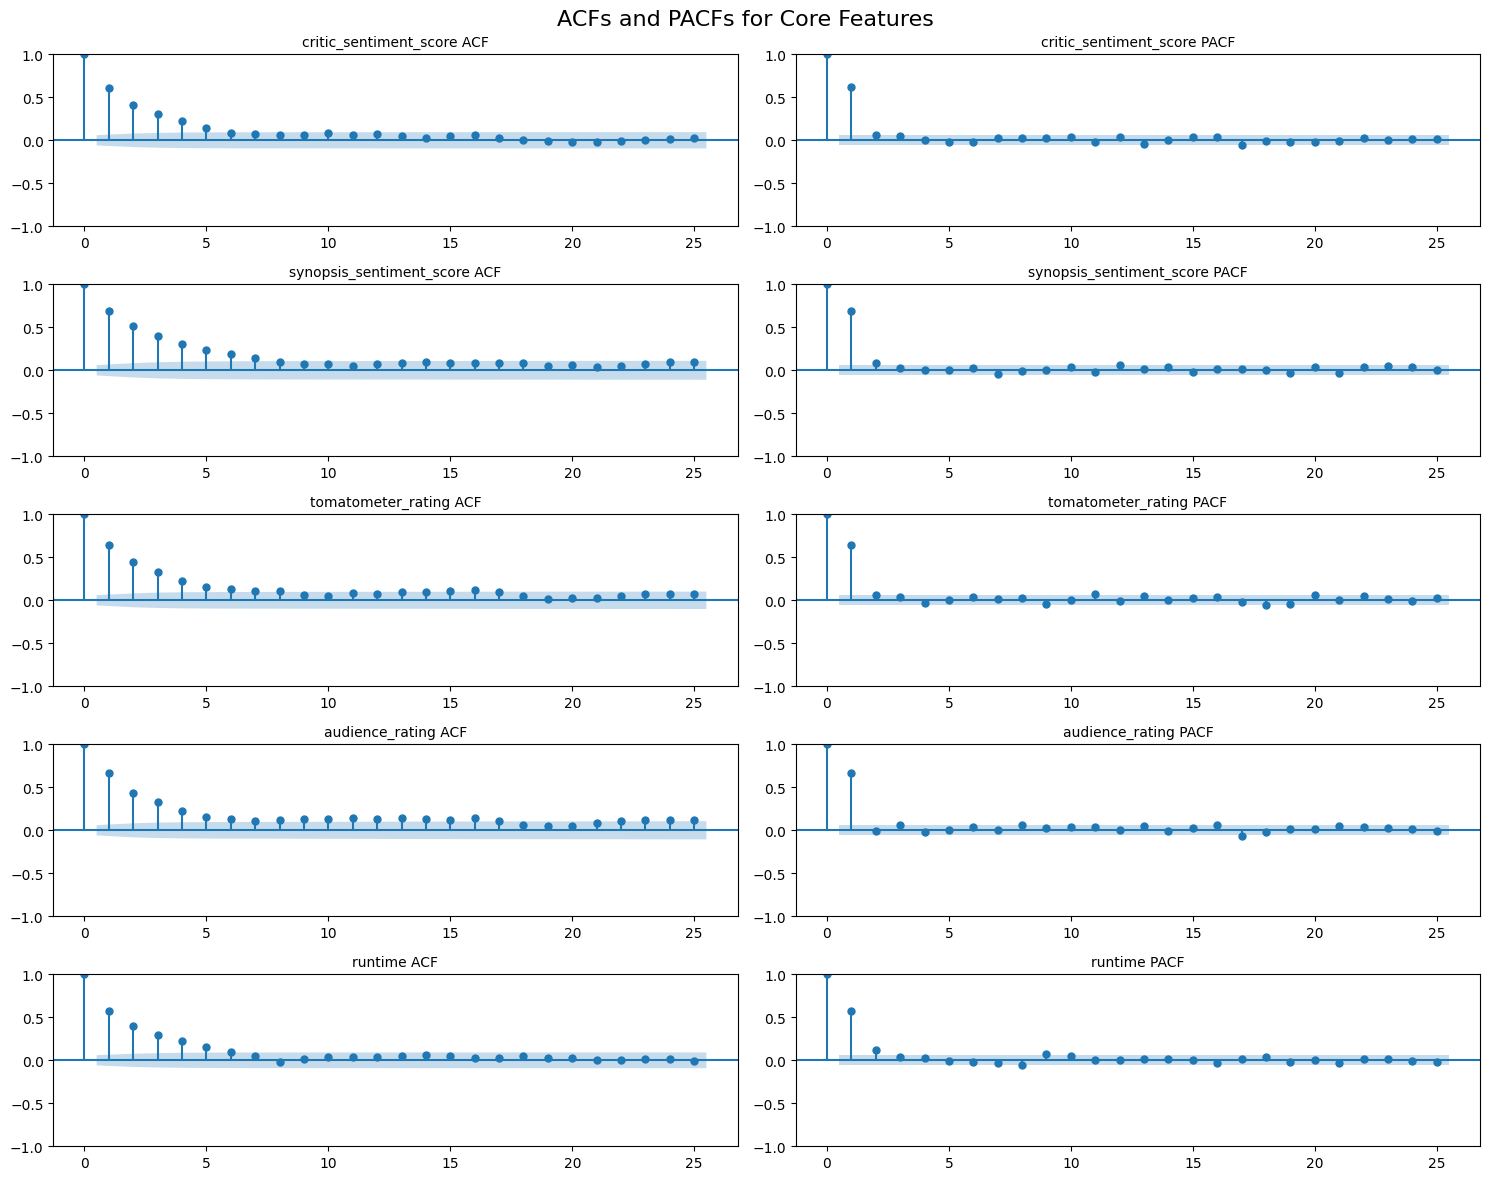

In [43]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 12))
f.suptitle('ACFs and PACFs for Core Features', fontsize=16)

for i, column in enumerate(core_columns):
    plot_acf(df[column], lags=25, ax=ax[i,0])
    ax[i,0].set_title(f'{column} ACF', fontsize=10)
    plot_pacf(df[column], lags=25, ax=ax[i,1])
    ax[i,1].set_title(f'{column} PACF', fontsize=10)

plt.tight_layout()
plt.show()

## Part E: Modeling

In [44]:
#!pip install scikit-learn
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['critic_sentiment_score']

folds = TimeSeriesSplit(n_splits=N_SPLITS)
folds

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)

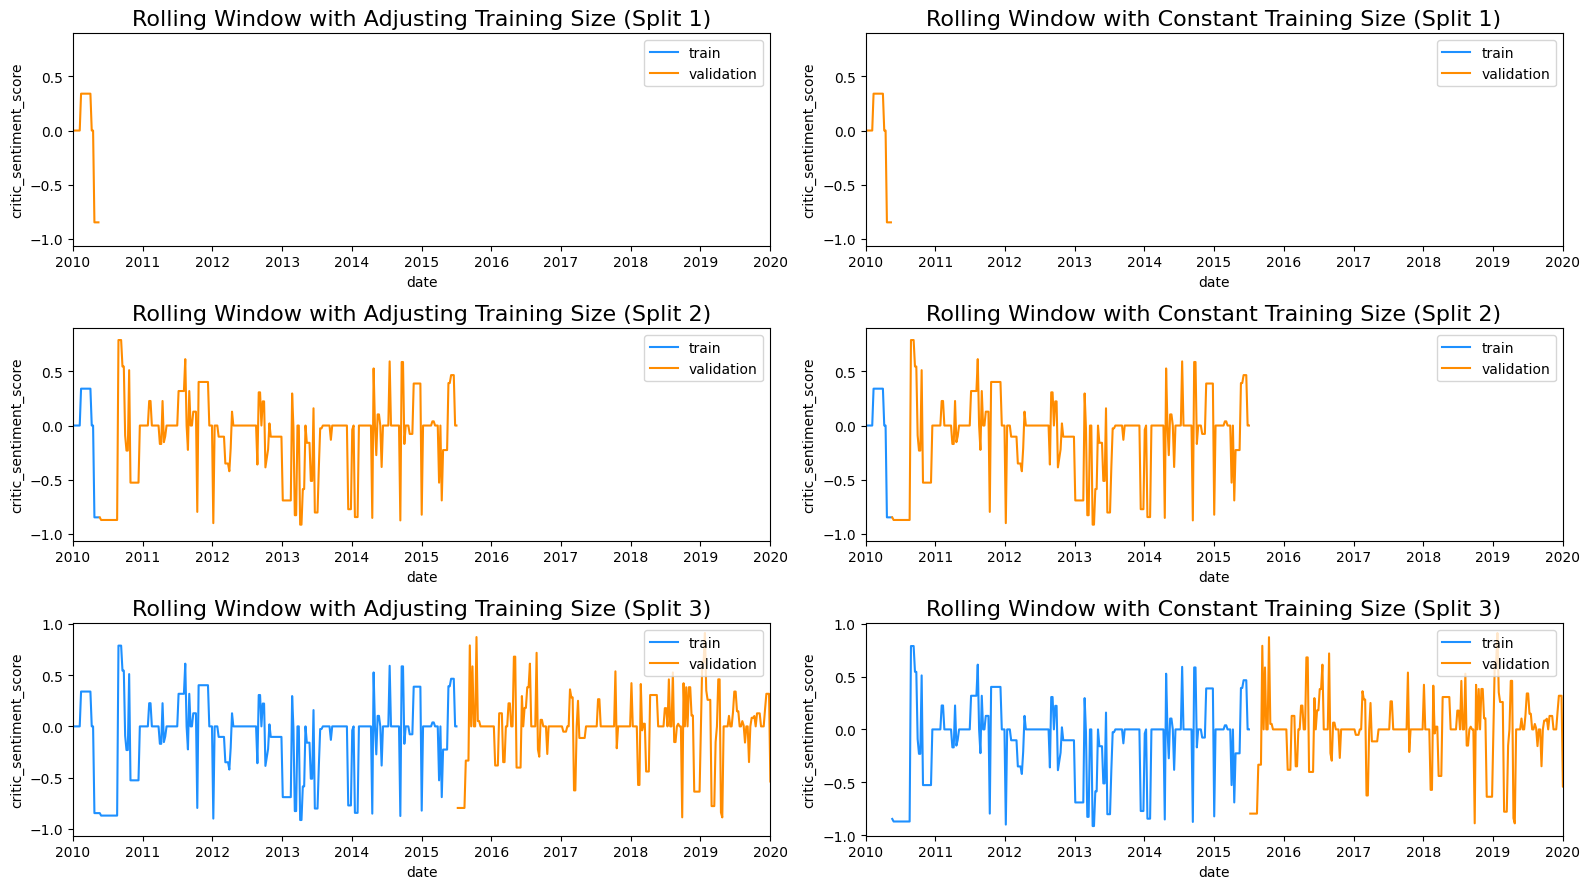

In [45]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])
    ax[i, 1].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])
    
plt.tight_layout()
plt.show()

The idea with this plot is to understand which train and test sets should we use to fit the model in each iteration.

### Part E2: Univariate Time Series


#### Univariate time series:

Only one variable is varying over time. For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature.

In [46]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'critic_sentiment_score']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

912 161


### Part E3: Prophet

The first model (which also can handle multivariate problems) we are going to try is Facebook Prophet.

Prophet, or “Facebook Prophet,” is an open-source library for univariate (one variable) time series forecasting developed by Facebook.

Prophet implements what they refer to as an additive time series forecasting model, and the implementation supports trends, seasonality, and holidays.

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from prophet import Prophet


# Train the model
model = Prophet()
model.fit(train)

17:16:20 - cmdstanpy - INFO - Chain [1] start processing
17:16:20 - cmdstanpy - INFO - Chain [1] done processing


In [48]:
x_valid = model.make_future_dataframe(periods=test_size, freq='w')
x_valid.head()

ds
0 2000-02-04
1 2000-02-11
2 2000-02-18
3 2000-02-25
4 2000-03-03

In [49]:
# Predict on valid set
y_pred = model.predict(x_valid)
y_pred.head(3)

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2000-02-04 -0.221207   -0.787437    0.143131    -0.221207    -0.221207   
1 2000-02-11 -0.220870   -0.753635    0.209791    -0.220870    -0.220870   
2 2000-02-18 -0.220532   -0.666570    0.290794    -0.220532    -0.220532   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.125787             -0.125787             -0.125787 -0.125787   
1       -0.050142             -0.050142             -0.050142 -0.050142   
2        0.007116              0.007116              0.007116  0.007116   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.125787     -0.125787                   0.0   
1     -0.050142     -0.050142                   0.0   
2      0.007116      0.007116                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0 -0.346994  
1                         0.0                         0.0 -0.271012  
2                         0.0                         0.0 -0.213416

In [50]:
#Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

#print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))
print('RMSE: {}'.format(score_rmse))

RMSE: 0.35526263872334946


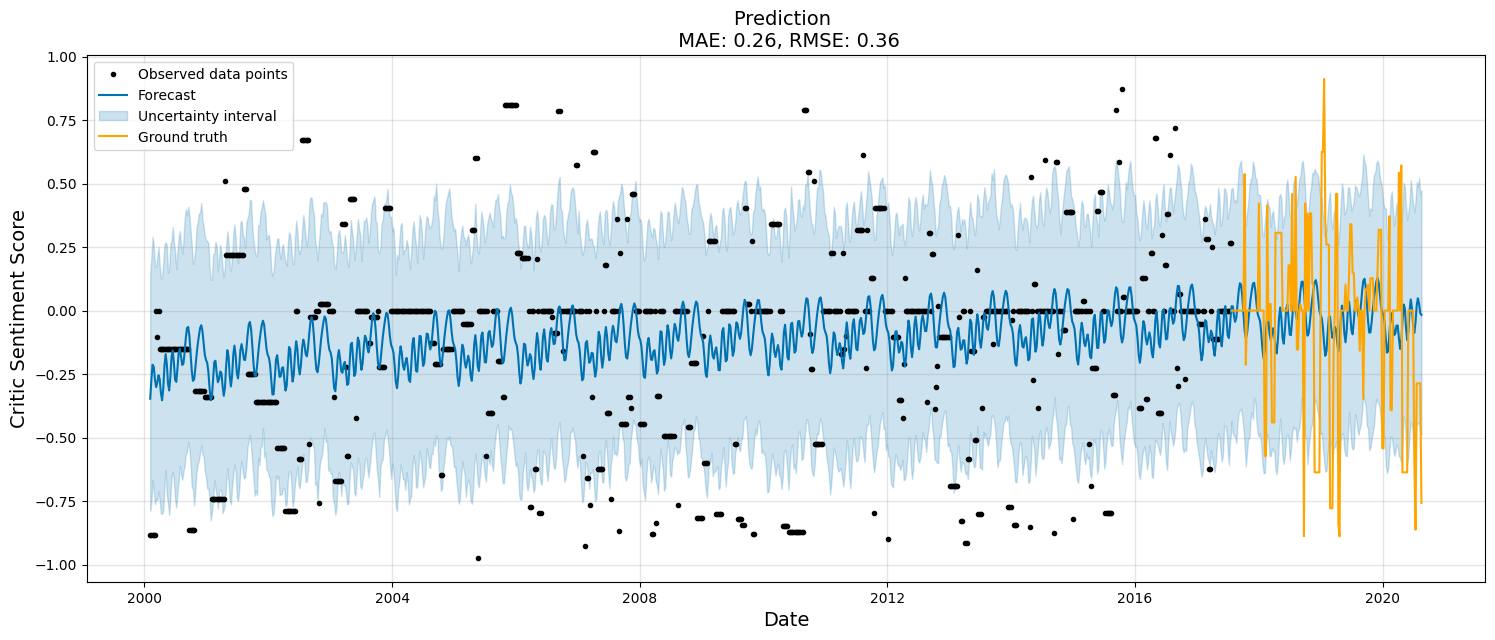

In [51]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Critic Sentiment Score', fontsize=14)

plt.show()

### Part E4: ARIMA

The Auto-Regressive Integrated Moving Average (ARIMA) model describes the autocorrelations in the data. The model assumes that the time-series is stationary. It consists of three main parts:

Auto-Regressive (AR) filter (long term):

y
t
=
c
+
α
1
y
t
−
1
+
…
α
p
y
t
−
p
+
ϵ
t
=
c
+
∑
p
i
=
1
α
i
y
t
−
i
+
ϵ
t
  -> p

Integration filter (stochastic trend)

-> d

Moving Average (MA) filter (short term):

y
t
=
c
+
ϵ
t
+
β
1
ϵ
t
−
1
+
⋯
+
β
q
ϵ
t
−
q
=
c
+
ϵ
t
+
∑
q
i
=
1
β
i
ϵ
t
−
i
  -> q

ARIMA:  
y
t
=
c
+
α
1
y
t
−
1
+
⋯
+
α
p
y
t
−
p
+
ϵ
t
+
β
1
ϵ
t
−
1
+
⋯
+
β
q
ϵ
t
−
q
 
ARIMA( p, d, q)

p: Lag order (reference PACF in Autocorrelation Analysis)

d: Degree of differencing. (reference Differencing in Stationarity)

q: Order of moving average (check out ACF in Autocorrelation Analysis)

Steps to analyze ARIMA

Step 1 — Check stationarity: If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast. .

Step 2 — Difference: If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.

Step 3 — Filter out a validation sample: This will be used to validate how accurate our model is. Use train test validation split to achieve this

Step 4 — Select AR and MA terms: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.

Step 5 — Build the model: Build the model and set the number of periods to forecast to N (depends on your needs).

Step 6 — Validate model: Compare the predicted values to the actuals in the validation sample.

In [52]:
from statsmodels.tsa.arima.model import ARIMA

# Fit model
model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred = model_fit.forecast(161)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 0.3410326183527902


## E5: Auto-ARIMA

In [46]:
#!pip install pmdarima

In [53]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=359.316, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=903.571, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=365.785, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=542.465, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=356.896, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=361.625, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=356.712, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=355.022, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=343.922, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=348.022, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=345.897, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 1.135 seconds
                               SARIMAX Results                                
Dep. Variable:           

As we saw in the previous Steps, AutoARIMA (auto_arima) validates that (0,0,0) is the best configuration for (p,d,q). --> will retool later

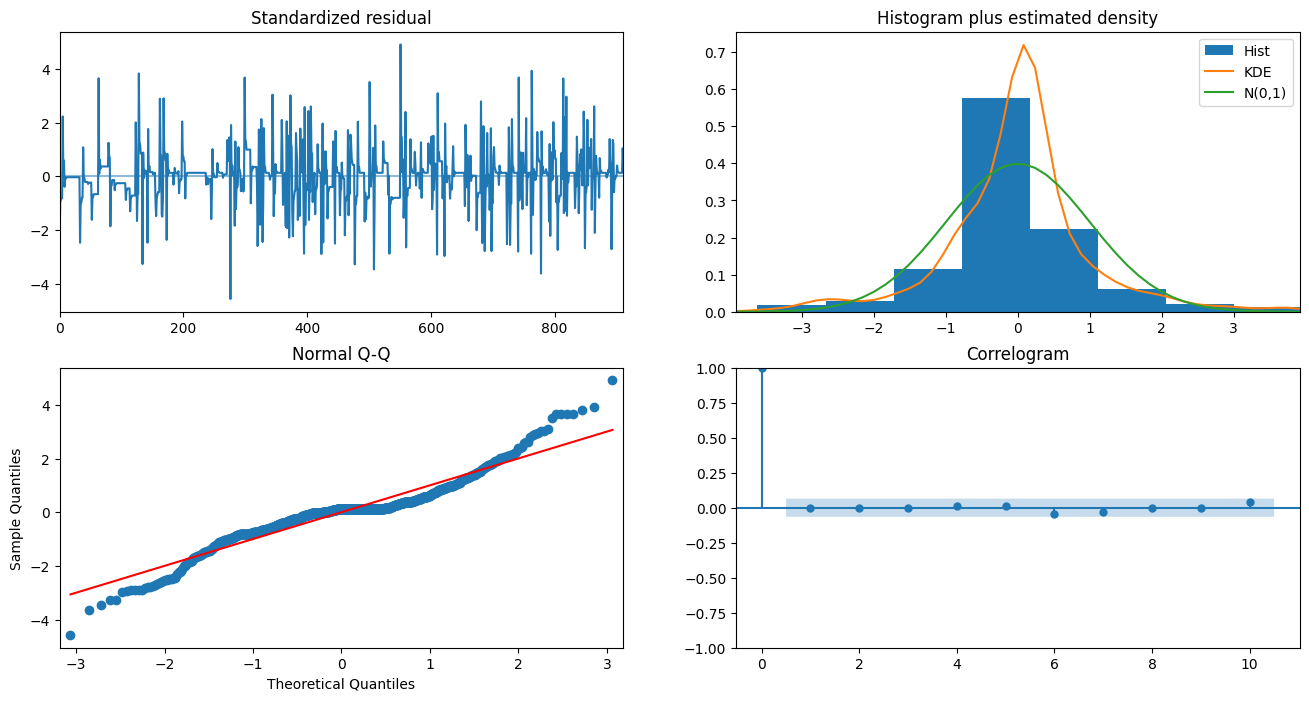

In [54]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

#### So how to interpret the plot diagnostics?

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance between (-3, 3).

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: The most part of the blue dots are over the red line, so it seems that the distribution in not very skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.

## Part E6: Models for Multivariate Time Series

In [55]:
df.columns[0:10]

Index(['date', 'critic_sentiment_score', 'synopsis_sentiment_score',
       'tomatometer_rating', 'audience_rating', 'runtime', 'year', 'month',
       'day', 'day_of_year'],
      dtype='object')

In [56]:
feature_columns = [
    'synopsis_sentiment_score',
    'tomatometer_rating',
    'audience_rating',
    'runtime'
]
target_column = ['critic_sentiment_score']

train_size = int(0.85 * len(df))

multivariate_df = df[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

ds       y  synopsis_sentiment_score  tomatometer_rating  \
0 2000-02-04 -0.8848                   -0.9231                39.0   
1 2000-02-11 -0.8848                   -0.9231                39.0   
2 2000-02-18 -0.8848                   -0.9231                39.0   
3 2000-02-25 -0.8848                   -0.9231                39.0   
4 2000-03-03 -0.8848                   -0.9231                39.0   

   audience_rating  runtime  
0             37.0    116.0  
1             37.0    116.0  
2             37.0    116.0  
3             37.0    116.0  
4             37.0    116.0

### Multivariate Prophet

In [57]:
from fbprophet import Prophet

# Train the model
model = Prophet()
model.add_regressor('synopsis_sentiment_score')
model.add_regressor('tomatometer_rating')
model.add_regressor('audience_rating')
model.add_regressor('runtime')


# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -128.247
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       435.069    0.00368119       96.2943   3.766e-05       0.001      119  LS failed, Hessian reset 
      99       435.322   3.20584e-05       62.0953      0.1678      0.1678      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       435.376   0.000408007       94.6082   4.757e-06       0.001      195  LS failed, Hessian reset 
     155       435.393   1.29028e-06       82.7921   1.383e-08       0.001      288  LS failed, Hessian reset 
     173       435.393   2.39155e-08       84.9116      0.3364           1      313   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
RMSE: 0.35407119329982173


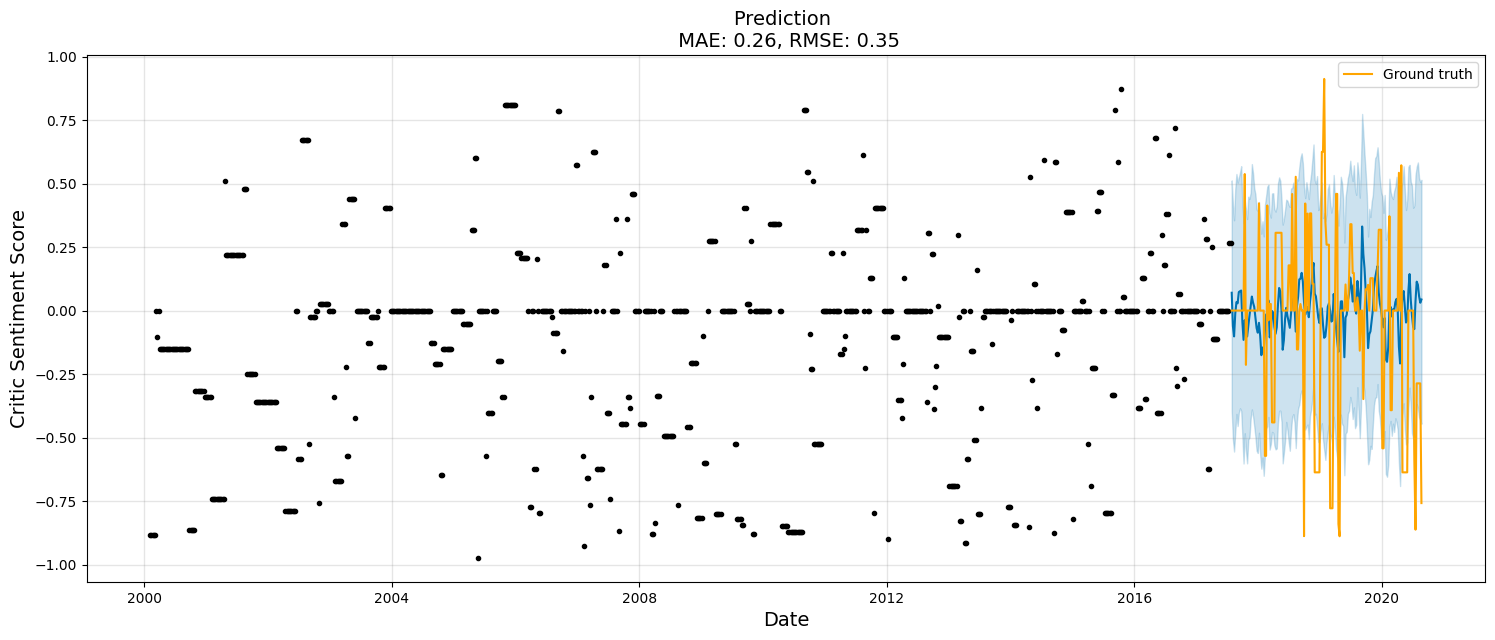

In [58]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Critic Sentiment Score', fontsize=14)

plt.show()